# Отчет по анализу образовательных предпочтений студентов
## Сегментация студентов на основе опроса

**Выполнил:** Антипов Арсений

## 1. Введение <a id="intro"></a>

В рамках данного исследования проводится анализ и сегментация студентов на основе их образовательных предпочтений.
Основная цель — выявить различные группы студентов для:
- оптимизации учебных материалов,
- разработки эффективных программ поддержки,
- улучшения взаимодействия в образовательном процессе.

## 2. Понимание задачи исследования <a id="business_understanding"></a>

### Преимущества выделения групп студентов:
- Индивидуализация обучения: каждая группа получает оптимальный формат материалов
- Целевая поддержка: выявление студентов, требующих дополнительного внимания
- Оптимизация процесса: настройка технологий под конкретные группы

### Основные вопросы исследования:
- Какие способы подачи материала наиболее востребованы?
- Насколько важна интерактивность и обратная связь?
- Какие образовательные платформы показывают лучшие результаты?

In [33]:
# Импортируем необходимые библиотеки для комплексного анализа
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Инструменты для кластерного анализа и машинного обучения
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA

# Библиотеки для визуализации в пониженной размерности
import umap

# Дополнительные инструменты для статистической обработки
from scipy.stats import chi2_contingency
from itertools import combinations
from collections import Counter
import os

# Настройка стиля визуализации
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print("Библиотеки для анализа данных успешно загружены")
print(f"Используется pandas версии: {pd.__version__}")
print(f"Модули машинного обучения готовы к работе")
print(f"Инструменты визуализации инициализированы")

Библиотеки для анализа данных успешно загружены
Используется pandas версии: 2.3.0
Модули машинного обучения готовы к работе
Инструменты визуализации инициализированы


## 3. Понимание данных

### Загрузка данных

In [34]:
# Загрузка данных из Excel-файла
try:
    df = pd.read_excel('data/dlia studentov.xlsx')
    print("Данные успешно импортированы из файла")
except FileNotFoundError:
    print("Внимание: файл 'dlia studentov.xlsx' не найден")
    print("Проверьте наличие файла в папке data")
    # Создаем тестовый набор данных
    print("\n📝 Генерация тестового набора данных...")

    # Создание примера данных для демонстрации
    np.random.seed(42)
    n_students = 200

    df = pd.DataFrame({
        'Факультет/Институт': np.random.choice(['ИТ', 'Экономический', 'Гуманитарный', 'Технический'], n_students),
        'Предпочитаю_Moodle': np.random.choice([0, 1], n_students),
        'Активная_обратная_связь': np.random.choice([0, 1], n_students),
        'Видео_материалы': np.random.choice([0, 1], n_students),
        'Текстовые_материалы': np.random.choice([0, 1], n_students),
        'Групповые_проекты': np.random.choice([0, 1], n_students),
        'Индивидуальные_задания': np.random.choice([0, 1], n_students),
        'Онлайн_консультации': np.random.choice([0, 1], n_students),
        'Очные_встречи': np.random.choice([0, 1], n_students)
    })
    print("Тестовый набор данных создан")

# Вывод информации о структуре данных
print(f"\nРазмерность датасета: {df.shape[0]} наблюдений, {df.shape[1]} признаков")
print(f"\nДоступные признаки в наборе данных:")
for i, col in enumerate(df.columns, 1):
    print(f"{i:2d}. {col}")

Данные успешно импортированы из файла

Размерность датасета: 711 наблюдений, 23 признаков

Доступные признаки в наборе данных:
 1. ID
 2. Время создания
 3. На каком факультете/в каком институте Вы обучаетесь?
 4. Какая платформа для обучения дисциплине "ИНФОКОММУНИКАЦИОННЫЕ ТЕХНОЛОГИИ" использовалась?
 5. Был ли предусмотрен фидбек (отклик преподавателя на выполненное задание, например, указание ошибок и как их можно исправить)
 6. Необходим ли фидбек (отклик преподавателя на выполненное задание, например, указание ошибок и как их можно исправить) в электронном курсе?
 7. Был ли автоматический мониторинг присутствия студента на занятии (например, посредством QR-кодов)
 8. Необходим ли автоматический мониторинг присутствия студента на занятии (например, посредством QR-кодов) в электронном курсе?
 9. Материалы, представленные для практического задания, были в разных форматах (например, одновременно и текстовый, и видео)?
10. Необходимо ли представлять материалы для практического задания

In [35]:
# Первичный осмотр данных
print("Первые 5 строк датасета:")
print(df.head())

print("\nИнформация о типах данных:")
print(df.info())

print("\nСтатическое описание")
print(df.describe())

print("\nПроверка пропущенных значений:")
missing_data = df.isnull().sum()
print(missing_data)
print(f"\nВсего пропущенных значений: {missing_data.sum()}")

if missing_data.sum() > 0:
    print("\nСтолбцы с пропущенными значениями:")
    for col, missing in missing_data[missing_data > 0].items():
        print(f"- {col}: {missing} ({missing/len(df)*100:.1f}%)")
else:
    print("Пропущенные значения не обнаружены!")

Первые 5 строк датасета:
           ID       Время создания  \
0  1408291245  2023-06-07 20:41:17   
1  1405883214  2023-06-05 09:02:21   
2  1405869646  2023-06-05 08:44:38   
3  1405856131  2023-06-05 08:26:39   
4  1405854542  2023-06-05 08:24:47   

  На каком факультете/в каком институте Вы обучаетесь?  \
0                 институт истории и социальных наук     
1                                институт педагогики     
2                                институт педагогики     
3                                институт педагогики     
4                                институт педагогики     

  Какая платформа для обучения дисциплине "ИНФОКОММУНИКАЦИОННЫЕ ТЕХНОЛОГИИ" использовалась?  \
0                                             Moodle                                          
1                                             Moodle                                          
2                                             Moodle                                          
3                

### Исследовательский анализ данных (EDA)

#### Анализ отдельных признаков

Проанализируем распределение ответов по каждому вопросу анкеты.

In [36]:
# Проверка структуры данных
print("Анализ структуры данных")
print("=" * 50)
print(f"Колонки в датасете ({len(df.columns)}):")
for i, col in enumerate(df.columns, 1):
    print(f"{i:2d}. {col}")

# Определяем колонку с факультетом (может быть разное название)
faculty_columns = [col for col in df.columns if any(word in col.lower() for word in ['факультет', 'институт', 'направление', 'специальность'])]

if faculty_columns:
    faculty_col = faculty_columns[0]
    print(f"\nНайдена колонка с факультетом: '{faculty_col}'")
else:
    faculty_col = None
    print(f"\nКолонка с факультетом не найдена")

# Определяем признаки для анализа
if faculty_col:
    analysis_features = [col for col in df.columns if col != faculty_col]
else:
    analysis_features = list(df.columns)

print(f"\nПризнаки для анализа: {len(analysis_features)}")
for i, feature in enumerate(analysis_features, 1):
    print(f"{i:2d}. {feature}")

# Анализ распределения по факультетам (если есть)
if faculty_col:
    print(f"\nРаспределения по {faculty_col.upper()}")
    faculty_dist = df[faculty_col].value_counts()
    print(faculty_dist)
    print(f"\nПроцентное распределение:")
    print((faculty_dist / len(df) * 100).round(1))
else:
    print("\nИнформация о факультете/институте отсутствует")

# Анализ типов данных
print(f"\nАнализ типов данных:")
for col in df.columns:
    unique_vals = df[col].nunique()
    print(f"{col}: {unique_vals} уникальных значений - {list(df[col].unique())[:5]}{'...' if unique_vals > 5 else ''}")

Анализ структуры данных
Колонки в датасете (23):
 1. ID
 2. Время создания
 3. На каком факультете/в каком институте Вы обучаетесь?
 4. Какая платформа для обучения дисциплине "ИНФОКОММУНИКАЦИОННЫЕ ТЕХНОЛОГИИ" использовалась?
 5. Был ли предусмотрен фидбек (отклик преподавателя на выполненное задание, например, указание ошибок и как их можно исправить)
 6. Необходим ли фидбек (отклик преподавателя на выполненное задание, например, указание ошибок и как их можно исправить) в электронном курсе?
 7. Был ли автоматический мониторинг присутствия студента на занятии (например, посредством QR-кодов)
 8. Необходим ли автоматический мониторинг присутствия студента на занятии (например, посредством QR-кодов) в электронном курсе?
 9. Материалы, представленные для практического задания, были в разных форматах (например, одновременно и текстовый, и видео)?
10. Необходимо ли представлять материалы для практического задания в разных форматах (например, одновременно и текстовый, и видео)?
11. Были ли 

Визуализация распределений


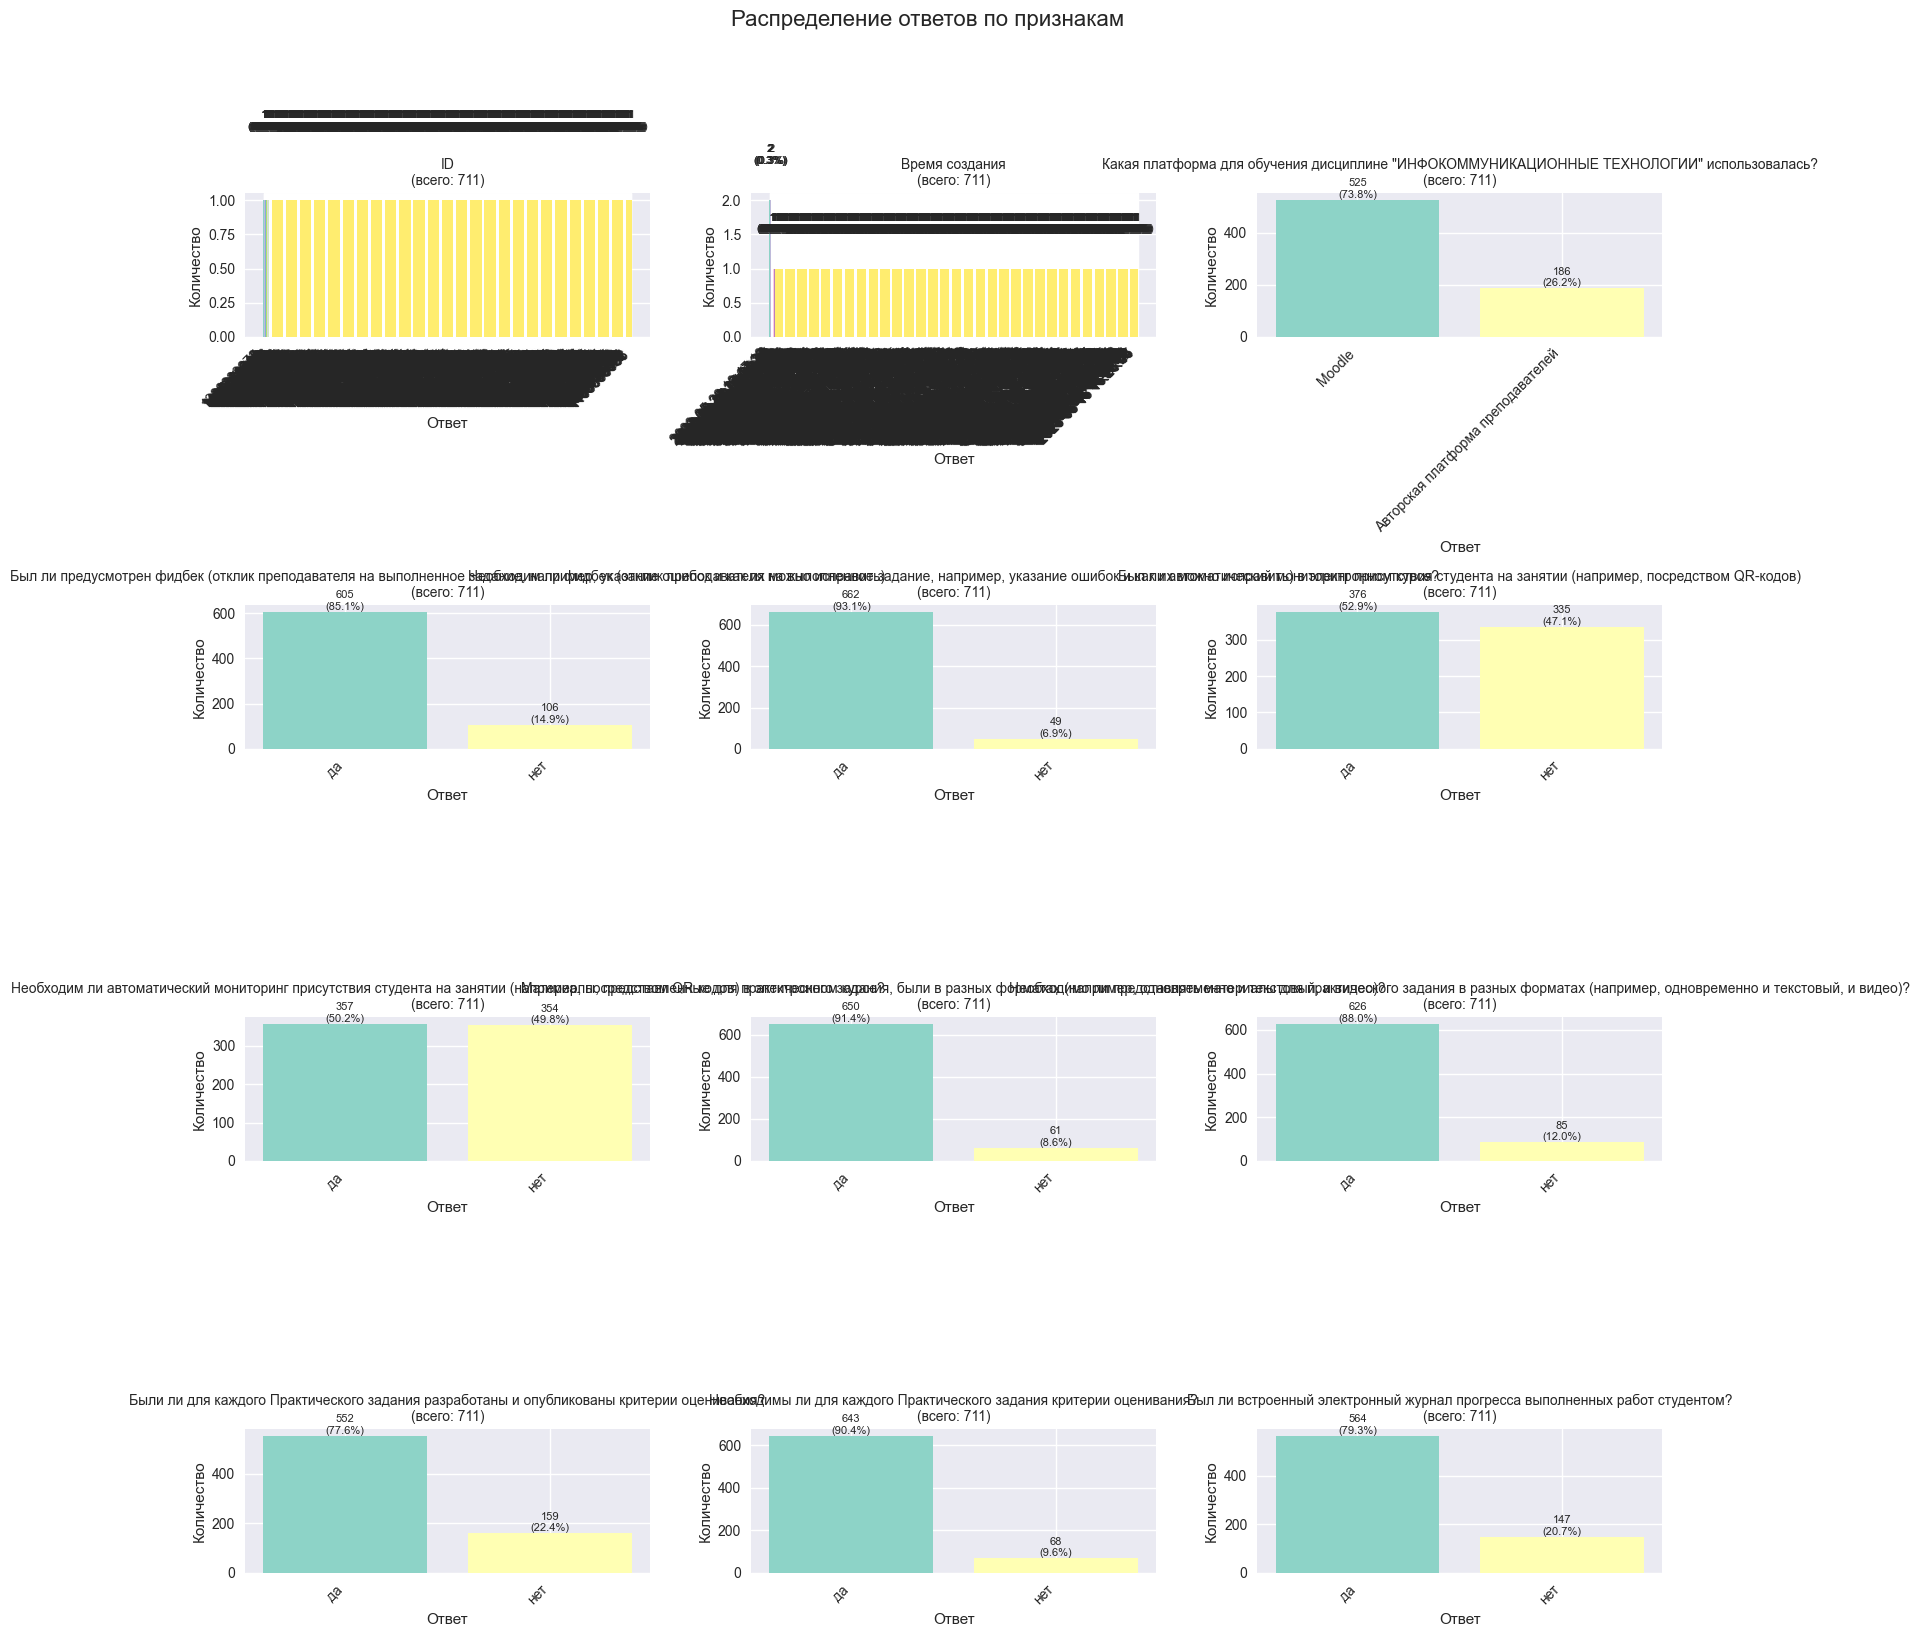

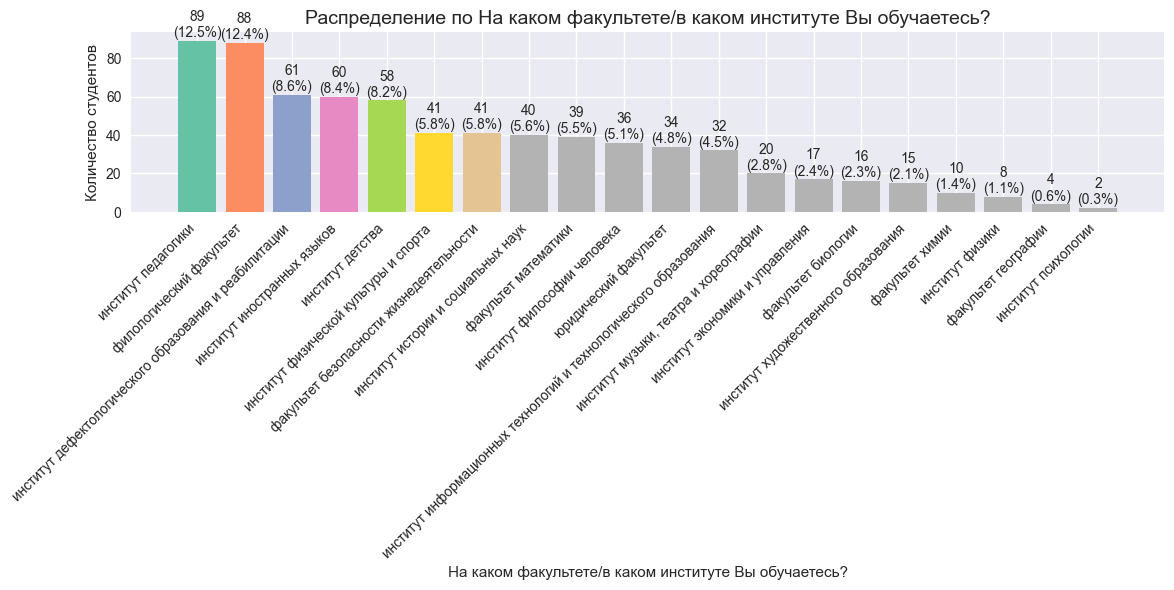


Визуализация завершена!


In [37]:
# Визуализация распределений признаков
print("Визуализация распределений")
print("=" * 40)

# Определяем количество признаков для отображения
features_to_plot = analysis_features[:12]  # Ограничиваем 12 признаками

if len(features_to_plot) > 0:
    # Вычисляем размер сетки
    n_features = len(features_to_plot)
    n_cols = 3
    n_rows = (n_features + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 4*n_rows))
    
    # Преобразуем в одномерный массив, если нужно
    if n_rows == 1 and n_cols == 1:
        axes = [axes]
    elif n_rows == 1 or n_cols == 1:
        axes = axes.flatten() if hasattr(axes, 'flatten') else [axes]
    else:
        axes = axes.flatten()
    
    for i, feature in enumerate(features_to_plot):
        if i < len(axes):
            try:
                counts = df[feature].value_counts()
                ax = axes[i]
                
                # Цвета для столбцов
                colors = plt.cm.Set3(np.arange(len(counts)))
                bars = ax.bar(range(len(counts)), counts.values, color=colors)
                
                # Настройка осей
                ax.set_title(f'{feature}\n(всего: {len(df)})', fontsize=10)
                ax.set_xlabel('Ответ')
                ax.set_ylabel('Количество')
                ax.set_xticks(range(len(counts)))
                ax.set_xticklabels(counts.index, rotation=45, ha='right')
                
                # Добавление процентов на столбцы
                for j, bar in enumerate(bars):
                    height = bar.get_height()
                    percentage = height/len(df)*100
                    ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                           f'{int(height)}\n({percentage:.1f}%)',
                           ha='center', va='bottom', fontsize=8)
                           
            except Exception as e:
                ax.text(0.5, 0.5, f'Ошибка\n{str(e)[:50]}', 
                       transform=ax.transAxes, ha='center', va='center')
                ax.set_title(f'{feature} (ошибка)')
    
    # Скрытие лишних подграфиков
    for i in range(len(features_to_plot), len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.suptitle('Распределение ответов по признакам', fontsize=16, y=1.02)
    plt.show()
else:
    print("Нет признаков для визуализации")

# Распределение по факультетам (если есть)
if faculty_col and faculty_col in df.columns:
    plt.figure(figsize=(12, 6))
    faculty_counts = df[faculty_col].value_counts()
    colors = plt.cm.Set2(np.arange(len(faculty_counts)))
    bars = plt.bar(range(len(faculty_counts)), faculty_counts.values, color=colors)
    
    plt.title(f'Распределение по {faculty_col}', fontsize=14)
    plt.xlabel(faculty_col)
    plt.ylabel('Количество студентов')
    plt.xticks(range(len(faculty_counts)), faculty_counts.index, rotation=45, ha='right')
    
    # Добавление процентов
    for i, bar in enumerate(bars):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                 f'{int(height)}\n({height/len(df)*100:.1f}%)',
                 ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
print(f"\nВизуализация завершена!")

#### Анализ связей между признаками

Для бинарных признаков рассчитаем коэффициенты Фи (φ) для оценки силы связи между переменными.

In [38]:
# Определяем бинарные признаки (столбцы с двумя уникальными значениями, кроме NaN)
binary_features = [
    col for col in df.columns
    if df[col].nunique(dropna=True) == 2
]

def phi_coefficient(x, y):
    """
    Рассчитывает коэффициент Фи для двух бинарных переменных
    """
    # Создание таблицы сопряженности
    crosstab = pd.crosstab(x, y)
    
    # Проверка размера таблицы
    if crosstab.shape != (2, 2):
        return np.nan
    
    # Извлечение значений a, b, c, d
    try:
        a = crosstab.iloc[1, 1]  # (1,1)
        b = crosstab.iloc[1, 0]  # (1,0)
        c = crosstab.iloc[0, 1]  # (0,1)
        d = crosstab.iloc[0, 0]  # (0,0)
        
        # Расчет коэффициента Фи
        numerator = a * d - b * c
        denominator = np.sqrt((a + b) * (c + d) * (a + c) * (b + d))
        
        if denominator == 0:
            return 0
        
        phi = numerator / denominator
        return phi
    except:
        return np.nan

# Расчет матрицы коэффициентов Фи
phi_matrix = pd.DataFrame(index=binary_features, columns=binary_features)

for i, feature1 in enumerate(binary_features):
    for j, feature2 in enumerate(binary_features):
        if i == j:
            phi_matrix.loc[feature1, feature2] = 1.0
        elif i < j:
            phi_coef = phi_coefficient(df[feature1], df[feature2])
            phi_matrix.loc[feature1, feature2] = phi_coef
            phi_matrix.loc[feature2, feature1] = phi_coef

# Преобразование в числовой формат
phi_matrix = phi_matrix.astype(float)

print("Матрица коэффициентов Фи рассчитана")
print(f"Размер матрицы: {phi_matrix.shape}")

Матрица коэффициентов Фи рассчитана
Размер матрицы: (20, 20)


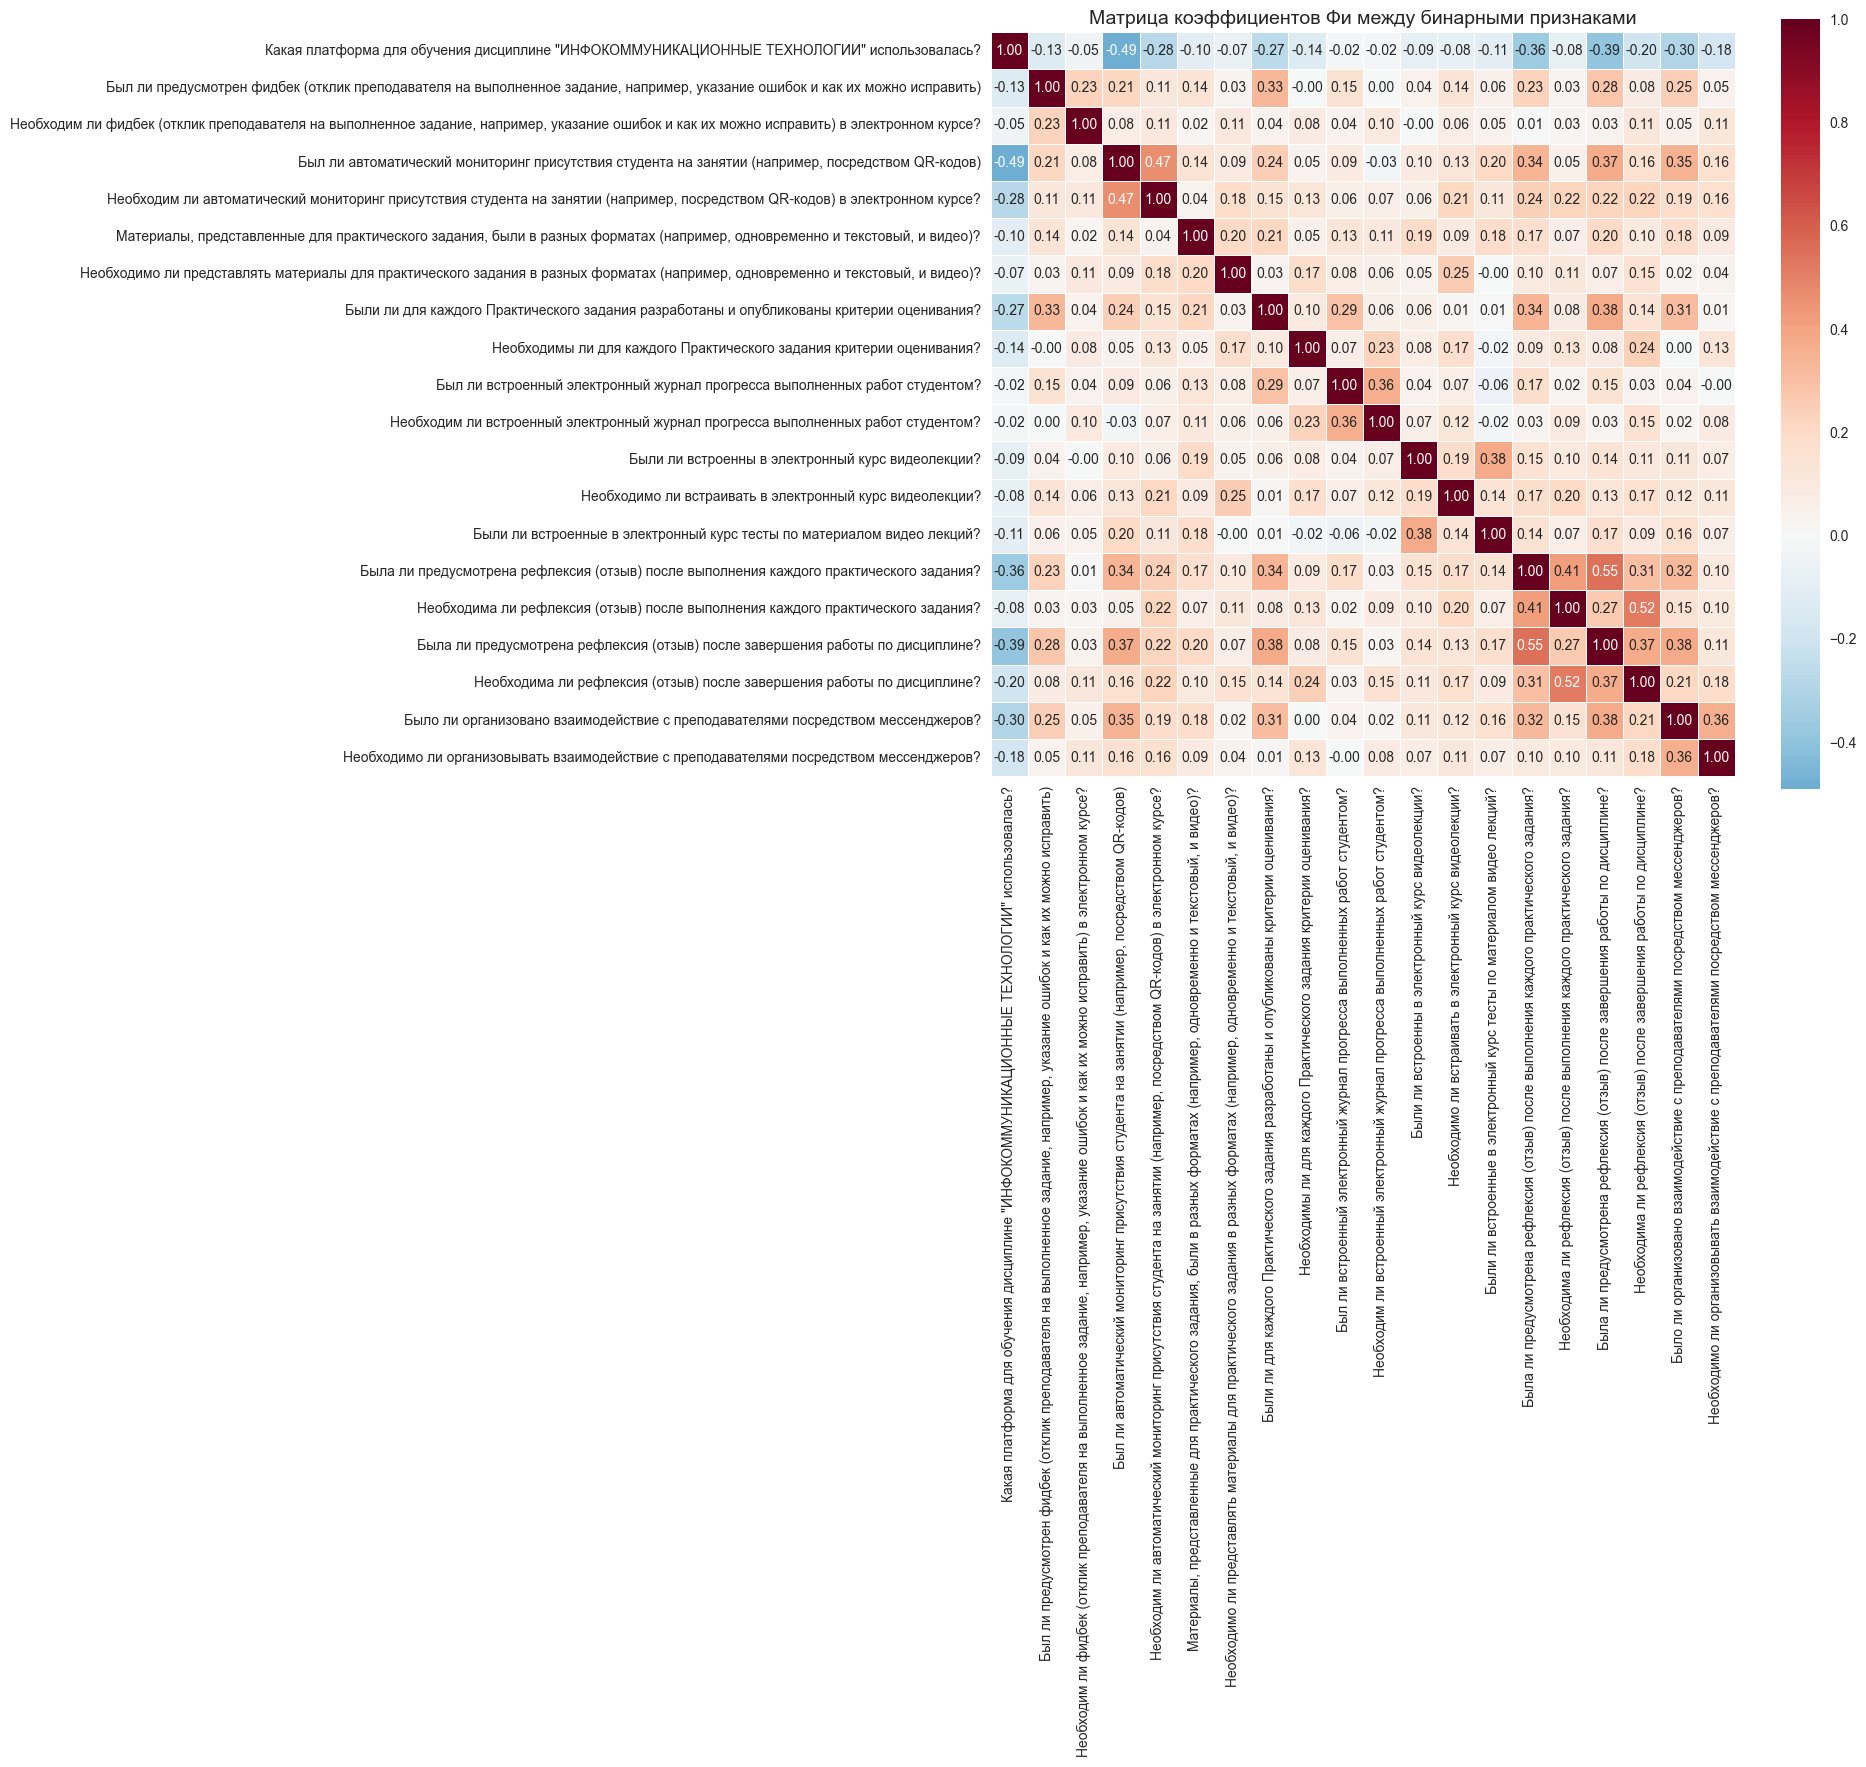

Анализ связей между признаками

Топ-10 самых сильных связей:
 1. Была ли предусмотрена рефлексия (отзыв) после выполнения каждого практического задания? ↔ Была ли предусмотрена рефлексия (отзыв) после завершения работы по дисциплине?: φ = 0.546 (прямая сильная связь)
 2. Необходима ли рефлексия (отзыв) после выполнения каждого практического задания? ↔ Необходима ли рефлексия (отзыв) после завершения работы по дисциплине?: φ = 0.522 (прямая сильная связь)
 3. Какая платформа для обучения дисциплине "ИНФОКОММУНИКАЦИОННЫЕ ТЕХНОЛОГИИ" использовалась? ↔ Был ли автоматический мониторинг присутствия студента на занятии (например, посредством QR-кодов): φ = -0.491 (обратная сильная связь)
 4. Был ли автоматический мониторинг присутствия студента на занятии (например, посредством QR-кодов) ↔ Необходим ли автоматический мониторинг присутствия студента на занятии (например, посредством QR-кодов) в электронном курсе?: φ = 0.469 (прямая сильная связь)
 5. Была ли предусмотрена рефлексия (отзыв) пос

In [39]:
# Визуализация матрицы коэффициентов Фи
plt.figure(figsize=(12, 10))
sns.heatmap(phi_matrix, annot=True, cmap='RdBu_r', center=0, 
            square=True, linewidths=0.5, fmt='.2f')
plt.title('Матрица коэффициентов Фи между бинарными признаками', fontsize=14)
plt.tight_layout()
plt.show()

# Анализ наиболее сильных связей
print("Анализ связей между признаками")

# Извлечение верхнего треугольника матрицы (без диагонали)
mask = np.triu(np.ones_like(phi_matrix, dtype=bool), k=1)
phi_upper = phi_matrix.where(mask)

# Преобразование в Series для сортировки
phi_pairs = phi_upper.stack().sort_values(key=abs, ascending=False)

print("\nТоп-10 самых сильных связей:")
for i, (pair, coef) in enumerate(phi_pairs.head(10).items(), 1):
    feature1, feature2 = pair
    strength = "сильная" if abs(coef) > 0.3 else "умеренная" if abs(coef) > 0.1 else "слабая"
    direction = "прямая" if coef > 0 else "обратная"
    print(f"{i:2d}. {feature1} ↔ {feature2}: φ = {coef:.3f} ({direction} {strength} связь)")

# Статистика по силе связей
abs_phi = phi_pairs.abs()
strong_links = (abs_phi > 0.3).sum()
moderate_links = ((abs_phi > 0.1) & (abs_phi <= 0.3)).sum()
weak_links = (abs_phi <= 0.1).sum()

print(f"\nСтатистика связей:")
print(f"- Сильные связи (|φ| > 0.3): {strong_links}")
print(f"- Умеренные связи (0.1 < |φ| ≤ 0.3): {moderate_links}")
print(f"- Слабые связи (|φ| ≤ 0.1): {weak_links}")
print(f"- Всего пар: {len(phi_pairs)}")

## 4. Подготовка и обработка данных

### Предварительная подготовка данных для анализа

На данном этапе выполним следующие задачи:
- Кодирование категориальных переменных в числовой формат
- Проверка и обработка отсутствующих значений
- Отбор значимых признаков для кластеризации
- Применение UMAP для снижения размерности и визуализации

In [40]:
# Подготовка данных для кластеризации
print("Подготовка данных\n")

# Проверка текущего состояния данных
print("Исходные данные:")
print(f"Размерность: {df.shape}")
print(f"Типы данных:\n{df.dtypes}\n")

# Создание копии данных для обработки
df_processed = df.copy()

# Кодирование бинарных признаков (если они еще не в числовом формате)
print("Обработка бинарных признаков...")
for feature in binary_features:
    if df_processed[feature].dtype == 'object':
        # Если признак текстовый, преобразуем в числовой
        unique_values = df_processed[feature].unique()
        print(f"Признак {feature}: {unique_values}")
        df_processed[feature] = pd.Categorical(df_processed[feature]).codes
    else:
        print(f"Признак {feature}: уже в числовом формате")

# Создание матрицы признаков для кластеризации (без факультета)
X = df_processed[binary_features].copy()

print(f"\nМатрица признаков для кластеризации:")
print(f"Размерность: {X.shape}")
print(f"Признаки: {list(X.columns)}")
print(f"\nПример данных:")
print(X.head())

# Проверка на пропущенные значения в матрице признаков
missing_check = X.isnull().sum()
print(f"\nПропущенные значения в матрице признаков: {missing_check.sum()}")
if missing_check.sum() > 0:
    print("Детали по пропущенным значениям:")
    print(missing_check[missing_check > 0])

Подготовка данных

Исходные данные:
Размерность: (711, 23)
Типы данных:
ID                                                                                                                                             int64
Время создания                                                                                                                                object
На каком факультете/в каком институте Вы обучаетесь?                                                                                          object
Какая платформа для обучения дисциплине "ИНФОКОММУНИКАЦИОННЫЕ ТЕХНОЛОГИИ" использовалась?                                                     object
Был ли предусмотрен фидбек (отклик преподавателя на выполненное задание, например, указание ошибок и как их можно исправить)                  object
Необходим ли фидбек (отклик преподавателя на выполненное задание, например, указание ошибок и как их можно исправить) в электронном курсе?    object
Был ли автоматический мониторинг п

In [41]:
# Стандартизация данных
print("\nСтандартизация данных\n")

# Для кластеризации бинарных данных стандартизация может быть полезна
# особенно для алгоритмов, чувствительных к масштабу
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

print("Статистики до стандартизации:")
print(X.describe().round(3))

print("\nСтатистики после стандартизации:")
print(X_scaled.describe().round(3))

# Сохраняем исходные данные для интерпретации
X_original = X.copy()
print(f"\nГотовы две версии данных:")
print(f"- X_original: исходные бинарные данные {X_original.shape}")
print(f"- X_scaled: стандартизированные данные {X_scaled.shape}")


Стандартизация данных

Статистики до стандартизации:
       Какая платформа для обучения дисциплине "ИНФОКОММУНИКАЦИОННЫЕ ТЕХНОЛОГИИ" использовалась?  \
count                                            711.000                                           
mean                                               0.262                                           
std                                                0.440                                           
min                                                0.000                                           
25%                                                0.000                                           
50%                                                0.000                                           
75%                                                1.000                                           
max                                                1.000                                           

       Был ли предусмотрен фидбек (отклик пре

### Снижение размерности с использованием UMAP

Применим UMAP (Uniform Manifold Approximation and Projection) для снижения размерности данных. Это поможет:
- Улучшить качество кластеризации
- Обеспечить возможность визуализации
- Выявить скрытые структуры в данных

In [42]:
# Подбор параметров UMAP
print("Подбор параметров UMAP\n")

# Функция для тестирования параметров UMAP
def test_umap_params(data, n_neighbors_list, min_dist_list, n_components=2):
    """
    Тестирует различные параметры UMAP и возвращает результаты
    """
    results = []
    
    for n_neighbors in n_neighbors_list:
        for min_dist in min_dist_list:
            try:
                # Создание и обучение UMAP
                umap_model = umap.UMAP(
                    n_neighbors=n_neighbors,
                    min_dist=min_dist,
                    n_components=n_components,
                    random_state=42,
                    metric='euclidean'
                )
                
                embedding = umap_model.fit_transform(data)
                
                # Простая оценка качества через разброс точек
                spread = np.std(embedding)
                
                results.append({
                    'n_neighbors': n_neighbors,
                    'min_dist': min_dist,
                    'spread': spread,
                    'embedding': embedding
                })
                
                print(f"n_neighbors={n_neighbors}, min_dist={min_dist}: spread={spread:.3f}")
                
            except Exception as e:
                print(f"Ошибка для n_neighbors={n_neighbors}, min_dist={min_dist}: {e}")
    
    return results

# Тестирование различных параметров
n_neighbors_options = [5, 10, 15, 30]
min_dist_options = [0.1, 0.25, 0.5, 0.8]

print("Тестирование параметров UMAP на стандартизированных данных:")
umap_results = test_umap_params(X_scaled, n_neighbors_options, min_dist_options, n_components=2)

# Выбор лучших параметров (можно использовать другие критерии)
best_result = max(umap_results, key=lambda x: x['spread'])
print(f"\nЛучшие параметры (по разбросу): n_neighbors={best_result['n_neighbors']}, min_dist={best_result['min_dist']}")

Подбор параметров UMAP

Тестирование параметров UMAP на стандартизированных данных:
n_neighbors=5, min_dist=0.1: spread=6.506
n_neighbors=5, min_dist=0.25: spread=6.451
n_neighbors=5, min_dist=0.5: spread=6.873
n_neighbors=5, min_dist=0.8: spread=6.489
n_neighbors=10, min_dist=0.1: spread=6.685
n_neighbors=10, min_dist=0.25: spread=7.284
n_neighbors=10, min_dist=0.5: spread=5.801
n_neighbors=10, min_dist=0.8: spread=6.108
n_neighbors=15, min_dist=0.1: spread=7.864
n_neighbors=15, min_dist=0.25: spread=7.032
n_neighbors=15, min_dist=0.5: spread=9.275
n_neighbors=15, min_dist=0.8: spread=10.378
n_neighbors=30, min_dist=0.1: spread=8.246
n_neighbors=30, min_dist=0.25: spread=5.946
n_neighbors=30, min_dist=0.5: spread=10.236
n_neighbors=30, min_dist=0.8: spread=7.157

Лучшие параметры (по разбросу): n_neighbors=15, min_dist=0.8


In [43]:
# Применение UMAP с оптимальными параметрами
print("\nПрименение UMAP\n")

# Используем найденные оптимальные параметры
optimal_n_neighbors = best_result['n_neighbors']
optimal_min_dist = best_result['min_dist']

# Создание 2D представления
umap_2d = umap.UMAP(
    n_neighbors=optimal_n_neighbors,
    min_dist=optimal_min_dist,
    n_components=2,
    random_state=42,
    metric='euclidean'
)

X_umap_2d = umap_2d.fit_transform(X_scaled)
print(f"2D UMAP: форма данных {X_umap_2d.shape}")

# Создание 3D представления
umap_3d = umap.UMAP(
    n_neighbors=optimal_n_neighbors,
    min_dist=optimal_min_dist,
    n_components=3,
    random_state=42,
    metric='euclidean'
)

X_umap_3d = umap_3d.fit_transform(X_scaled)
print(f"3D UMAP: форма данных {X_umap_3d.shape}")

# Создание DataFrame для удобства
X_umap_2d_df = pd.DataFrame(X_umap_2d, columns=['UMAP1', 'UMAP2'], index=X.index)
X_umap_3d_df = pd.DataFrame(X_umap_3d, columns=['UMAP1', 'UMAP2', 'UMAP3'], index=X.index)

print(f"\nПараметры UMAP:")
print(f"- n_neighbors: {optimal_n_neighbors}")
print(f"- min_dist: {optimal_min_dist}")
print(f"- metric: euclidean")
print(f"- random_state: 42")

print(f"\nСтатистики 2D UMAP:")
print(X_umap_2d_df.describe().round(3))

print(f"\nСтатистики 3D UMAP:")
print(X_umap_3d_df.describe().round(3))


Применение UMAP

2D UMAP: форма данных (711, 2)
3D UMAP: форма данных (711, 3)

Параметры UMAP:
- n_neighbors: 15
- min_dist: 0.8
- metric: euclidean
- random_state: 42

Статистики 2D UMAP:
         UMAP1    UMAP2
count  711.000  711.000
mean    15.051    5.211
std     12.014    4.785
min    -16.933   -1.094
25%     14.381    1.976
50%     17.484    4.293
75%     20.445    6.496
max     31.730   17.696

Статистики 3D UMAP:
         UMAP1    UMAP2    UMAP3
count  711.000  711.000  711.000
mean     9.450    7.722   11.245
std      7.238    6.583    3.827
min      2.118    1.163    1.322
25%      5.890    3.962    9.554
50%      7.489    5.645   11.528
75%      9.069    8.194   13.363
max     29.788   26.148   17.807



Визуализация UMAP



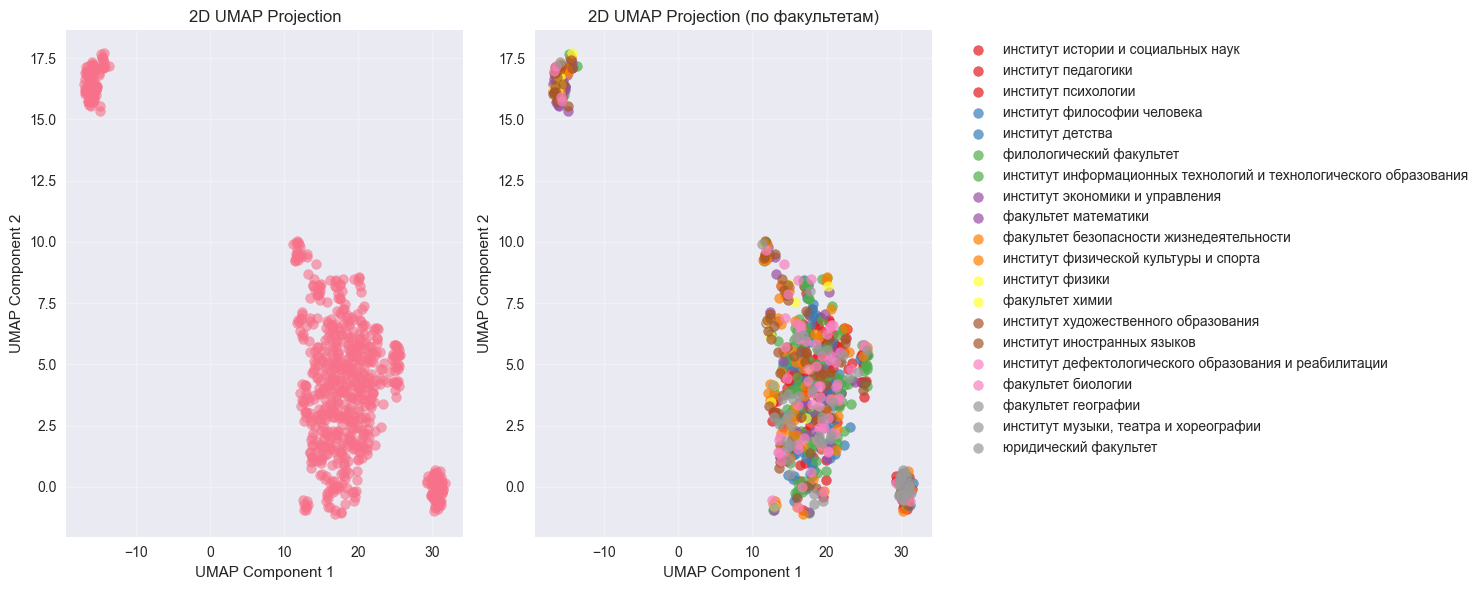

Подготовка данных завершена!

Итоговые наборы данных для кластеризации:
1. X_original: исходные бинарные данные (711, 20)
2. X_scaled: стандартизированные данные (711, 20)
3. X_umap_2d_df: 2D UMAP данные (711, 2)
4. X_umap_3d_df: 3D UMAP данные (711, 3)


In [44]:
# Визуализация результатов UMAP
print("\nВизуализация UMAP\n")

# 2D визуализация
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# График 2D UMAP
axes[0].scatter(X_umap_2d[:, 0], X_umap_2d[:, 1], alpha=0.6, s=50)
axes[0].set_xlabel('UMAP Component 1')
axes[0].set_ylabel('UMAP Component 2')
axes[0].set_title('2D UMAP Projection')
axes[0].grid(True, alpha=0.3)

# График 2D UMAP с цветовой кодировкой по факультетам
faculties = df['На каком факультете/в каком институте Вы обучаетесь?'].unique()
colors = plt.cm.Set1(np.linspace(0, 1, len(faculties)))

for i, faculty in enumerate(faculties):
    mask = df['На каком факультете/в каком институте Вы обучаетесь?'] == faculty
    axes[1].scatter(X_umap_2d[mask, 0], X_umap_2d[mask, 1], 
                   label=faculty, alpha=0.7, s=50, c=[colors[i]])

axes[1].set_xlabel('UMAP Component 1')
axes[1].set_ylabel('UMAP Component 2')
axes[1].set_title('2D UMAP Projection (по факультетам)')
axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 3D визуализация с Plotly
fig_3d = go.Figure()

# Добавляем точки для каждого факультета
for faculty in faculties:
    mask = df['На каком факультете/в каком институте Вы обучаетесь?'] == faculty
    fig_3d.add_trace(go.Scatter3d(
        x=X_umap_3d[mask, 0],
        y=X_umap_3d[mask, 1],
        z=X_umap_3d[mask, 2],
        mode='markers',
        name=faculty,
        marker=dict(size=5, opacity=0.7)
    ))

fig_3d.update_layout(
    title='3D UMAP Projection (по факультетам)',
    scene=dict(
        xaxis_title='UMAP Component 1',
        yaxis_title='UMAP Component 2',
        zaxis_title='UMAP Component 3'
    ),
    width=800,
    height=600
)

fig_3d.show()

print("Подготовка данных завершена!")
print(f"\nИтоговые наборы данных для кластеризации:")
print(f"1. X_original: исходные бинарные данные {X_original.shape}")
print(f"2. X_scaled: стандартизированные данные {X_scaled.shape}")
print(f"3. X_umap_2d_df: 2D UMAP данные {X_umap_2d_df.shape}")
print(f"4. X_umap_3d_df: 3D UMAP данные {X_umap_3d_df.shape}")

## 5. Моделирование (Modeling)

### Выбор алгоритмов кластеризации

Для анализа данных студентов применим несколько алгоритмов кластеризации:

1. **K-Means** - классический алгоритм для поиска сферических кластеров
2. **Agglomerative Clustering** - иерархический метод
3. **DBSCAN** - алгоритм на основе плотности
4. **Gaussian Mixture Models** - вероятностный подход
5. **Fuzzy C-Means** - нечеткая кластеризация

Каждый алгоритм будет применен к различным представлениям данных.

In [45]:
# Импорт дополнительных библиотек
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

# Попытка импорта Fuzzy C-Means
try:
    import skfuzzy as fuzz
    FUZZY_AVAILABLE = True
except ImportError:
    print("Библиотека skfuzzy недоступна. Нечеткая кластеризация будет пропущена.")
    FUZZY_AVAILABLE = False

# Функция для оценки качества кластеризации
def evaluate_clustering(X, labels, algorithm_name):
    """
    Оценивает качество кластеризации с помощью различных метрик
    """
    # Исключаем шумовые точки для DBSCAN
    valid_mask = labels != -1
    X_valid = X[valid_mask]
    labels_valid = labels[valid_mask]
    
    if len(np.unique(labels_valid)) < 2:
        return {
            'algorithm': algorithm_name,
            'n_clusters': len(np.unique(labels_valid)),
            'silhouette': np.nan,
            'davies_bouldin': np.nan,
            'calinski_harabasz': np.nan,
            'noise_ratio': np.sum(labels == -1) / len(labels) if -1 in labels else 0
        }
    
    # Расчет метрик
    silhouette = silhouette_score(X_valid, labels_valid)
    davies_bouldin = davies_bouldin_score(X_valid, labels_valid)
    calinski_harabasz = calinski_harabasz_score(X_valid, labels_valid)
    
    return {
        'algorithm': algorithm_name,
        'n_clusters': len(np.unique(labels_valid)),
        'silhouette': silhouette,
        'davies_bouldin': davies_bouldin,
        'calinski_harabasz': calinski_harabasz,
        'noise_ratio': np.sum(labels == -1) / len(labels) if -1 in labels else 0
    }

# Функция для определения оптимального количества кластеров
def find_optimal_clusters(X, max_clusters=10, algorithm='kmeans'):
    """
    Находит оптимальное количество кластеров методом локтя и силуэта
    """
    inertias = []
    silhouette_scores = []
    k_range = range(2, max_clusters + 1)
    
    for k in k_range:
        if algorithm == 'kmeans':
            model = KMeans(n_clusters=k, random_state=42, n_init=10)
            labels = model.fit_predict(X)
            inertias.append(model.inertia_)
        elif algorithm == 'gmm':
            model = GaussianMixture(n_components=k, random_state=42)
            labels = model.fit_predict(X)
            inertias.append(-model.score(X))  # Отрицательная логарифмическая вероятность
        
        if len(np.unique(labels)) > 1:
            silhouette_scores.append(silhouette_score(X, labels))
        else:
            silhouette_scores.append(0)
    
    return k_range, inertias, silhouette_scores

print("Функции для кластеризации готовы!")

Библиотека skfuzzy недоступна. Нечеткая кластеризация будет пропущена.
Функции для кластеризации готовы!


Подбор оптимального количества кластеров


Анализ для Исходные данные:
  Оптимальное количество кластеров: 2
  Лучший силуэт: 0.213

Анализ для Стандартизированные:
  Оптимальное количество кластеров: 2
  Лучший силуэт: 0.183

Анализ для 2D UMAP:
  Оптимальное количество кластеров: 2
  Лучший силуэт: 0.838

Анализ для 3D UMAP:
  Оптимальное количество кластеров: 2
  Лучший силуэт: 0.834


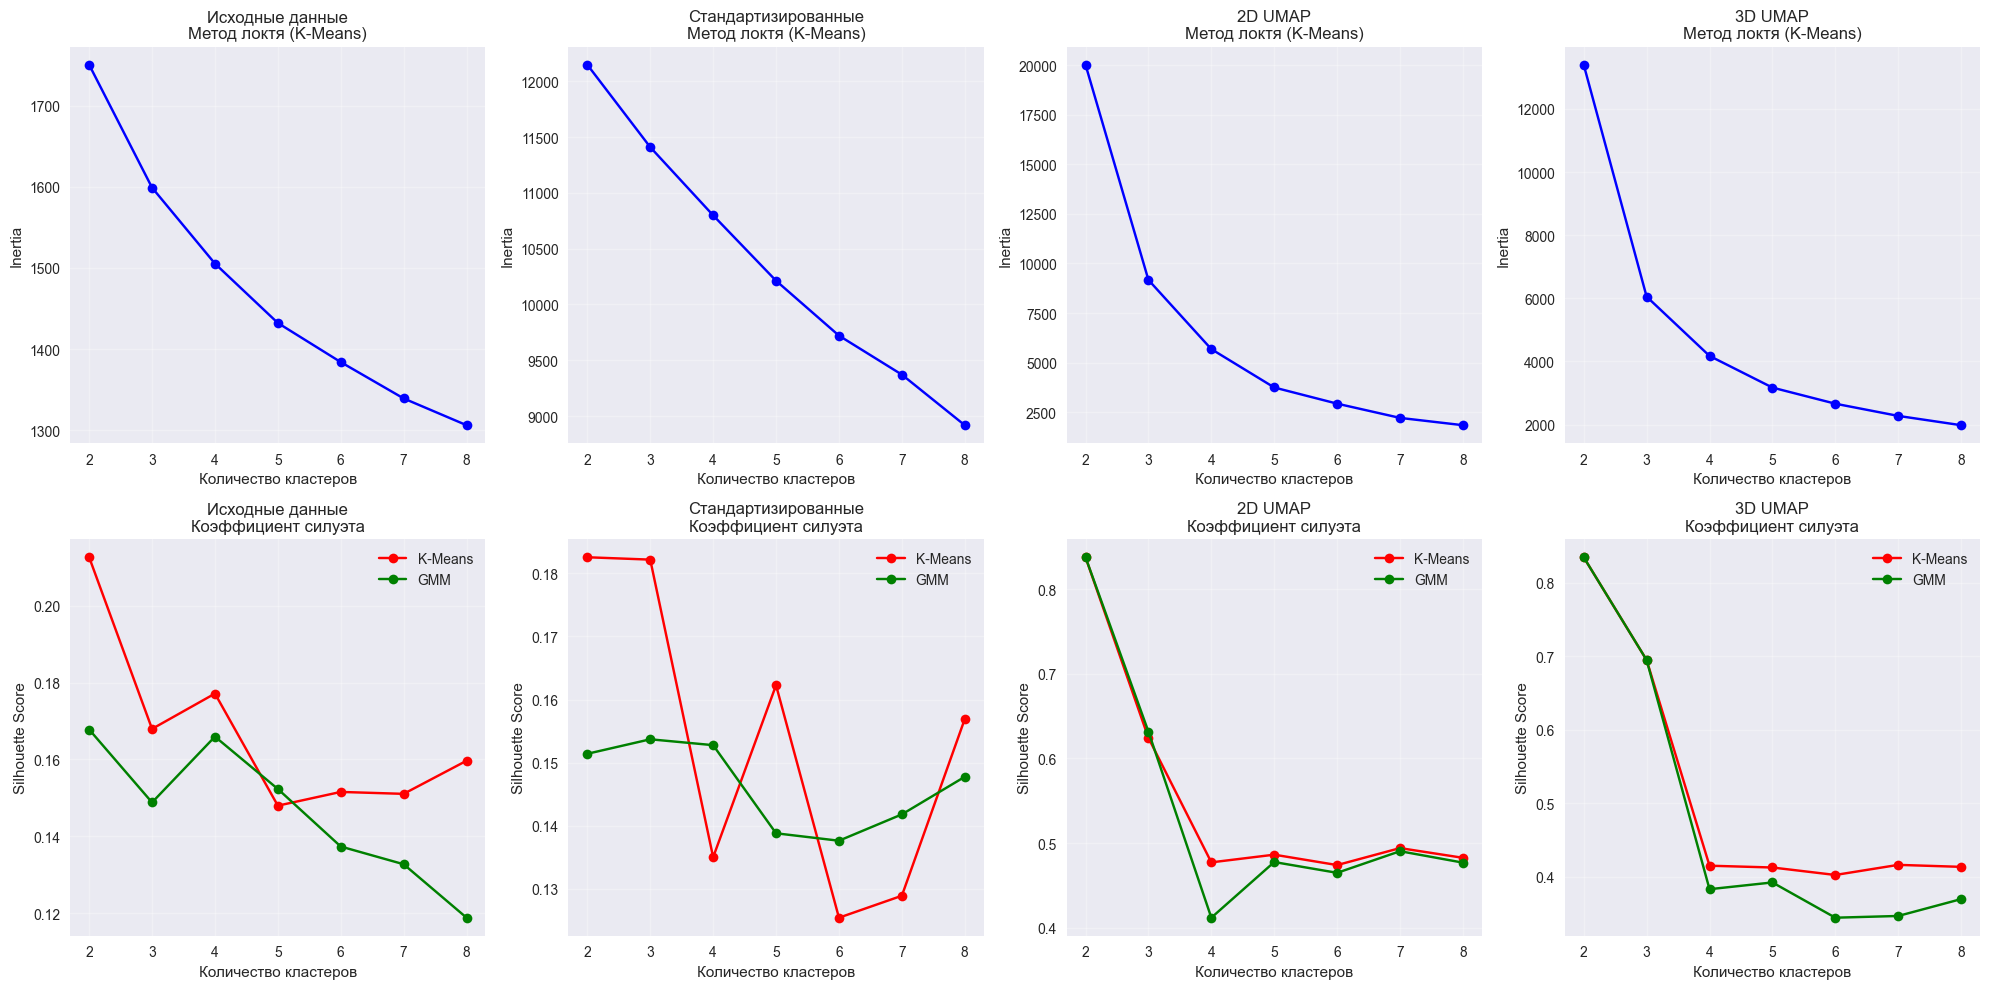


Сводка оптимальных параметров
Исходные данные: 2 кластеров (силуэт: 0.213)
Стандартизированные: 2 кластеров (силуэт: 0.183)
2D UMAP: 2 кластеров (силуэт: 0.838)
3D UMAP: 2 кластеров (силуэт: 0.834)


In [46]:
# Подбор оптимального количества кластеров
print("Подбор оптимального количества кластеров\n")

# Список наборов данных для тестирования
datasets = {
    'Исходные данные': X_original.values,
    'Стандартизированные': X_scaled.values,
    '2D UMAP': X_umap_2d,
    '3D UMAP': X_umap_3d
}

# Результаты для каждого набора данных
optimal_results = {}

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for idx, (dataset_name, data) in enumerate(datasets.items()):
    print(f"\nАнализ для {dataset_name}:")
    
    # K-Means
    k_range_km, inertias_km, silhouette_km = find_optimal_clusters(data, max_clusters=8, algorithm='kmeans')
    
    # GMM
    k_range_gmm, inertias_gmm, silhouette_gmm = find_optimal_clusters(data, max_clusters=8, algorithm='gmm')
    
    # Метод локтя для K-Means
    axes[idx].plot(k_range_km, inertias_km, 'bo-', label='K-Means Inertia')
    axes[idx].set_xlabel('Количество кластеров')
    axes[idx].set_ylabel('Inertia')
    axes[idx].set_title(f'{dataset_name}\nМетод локтя (K-Means)')
    axes[idx].grid(True, alpha=0.3)
    
    # Силуэт для K-Means
    axes[idx + 4].plot(k_range_km, silhouette_km, 'ro-', label='K-Means')
    axes[idx + 4].plot(k_range_gmm, silhouette_gmm, 'go-', label='GMM')
    axes[idx + 4].set_xlabel('Количество кластеров')
    axes[idx + 4].set_ylabel('Silhouette Score')
    axes[idx + 4].set_title(f'{dataset_name}\nКоэффициент силуэта')
    axes[idx + 4].legend()
    axes[idx + 4].grid(True, alpha=0.3)
    
    # Поиск оптимального количества кластеров
    best_k_silhouette = k_range_km[np.argmax(silhouette_km)]
    best_silhouette = max(silhouette_km)
    
    optimal_results[dataset_name] = {
        'best_k': best_k_silhouette,
        'best_silhouette': best_silhouette,
        'silhouette_scores': dict(zip(k_range_km, silhouette_km))
    }
    
    print(f"  Оптимальное количество кластеров: {best_k_silhouette}")
    print(f"  Лучший силуэт: {best_silhouette:.3f}")

plt.tight_layout()
plt.show()

# Сводка результатов
print("\nСводка оптимальных параметров")
for dataset_name, results in optimal_results.items():
    print(f"{dataset_name}: {results['best_k']} кластеров (силуэт: {results['best_silhouette']:.3f})")

In [47]:
# Тест: проверка доступности переменных
print("Тест: Проверка доступности переменных")
print("=" * 40)

# Проверяем, что переменные определены
variables_to_check = ['analysis_features', 'faculty_col', 'clustering_features']

for var_name in variables_to_check:
    try:
        var_value = eval(var_name)
        print(f"{var_name}: {type(var_value)} (длина: {len(var_value) if hasattr(var_value, '__len__') else 'N/A'})")
    except NameError:
        print(f"{var_name}: НЕ ОПРЕДЕЛЕНА")
    except Exception as e:
        print(f"{var_name}: ОШИБКА - {e}")

# Проверяем основные переменные DataFrame
df_variables = ['df', 'df_processed']
for var_name in df_variables:
    try:
        var_value = eval(var_name)
        print(f"{var_name}: {type(var_value)} {var_value.shape if hasattr(var_value, 'shape') else ''}")
    except NameError:
        print(f"{var_name}: НЕ ОПРЕДЕЛЕНА")
    except Exception as e:
        print(f"{var_name}: ОШИБКА - {e}")

Тест: Проверка доступности переменных
analysis_features: <class 'list'> (длина: 22)
faculty_col: <class 'str'> (длина: 52)
clustering_features: <class 'list'> (длина: 20)
df: <class 'pandas.core.frame.DataFrame'> (711, 23)
df_processed: <class 'pandas.core.frame.DataFrame'> (711, 23)


Подготовка данных для кластеризации
Признаки для кластеризации: 20
 1. Какая платформа для обучения дисциплине "ИНФОКОММУНИКАЦИОННЫЕ ТЕХНОЛОГИИ" использовалась?
 2. Был ли предусмотрен фидбек (отклик преподавателя на выполненное задание, например, указание ошибок и как их можно исправить)
 3. Необходим ли фидбек (отклик преподавателя на выполненное задание, например, указание ошибок и как их можно исправить) в электронном курсе?
 4. Был ли автоматический мониторинг присутствия студента на занятии (например, посредством QR-кодов)
 5. Необходим ли автоматический мониторинг присутствия студента на занятии (например, посредством QR-кодов) в электронном курсе?
 6. Материалы, представленные для практического задания, были в разных форматах (например, одновременно и текстовый, и видео)?
 7. Необходимо ли представлять материалы для практического задания в разных форматах (например, одновременно и текстовый, и видео)?
 8. Были ли для каждого Практического задания разработаны и опубликованы крит

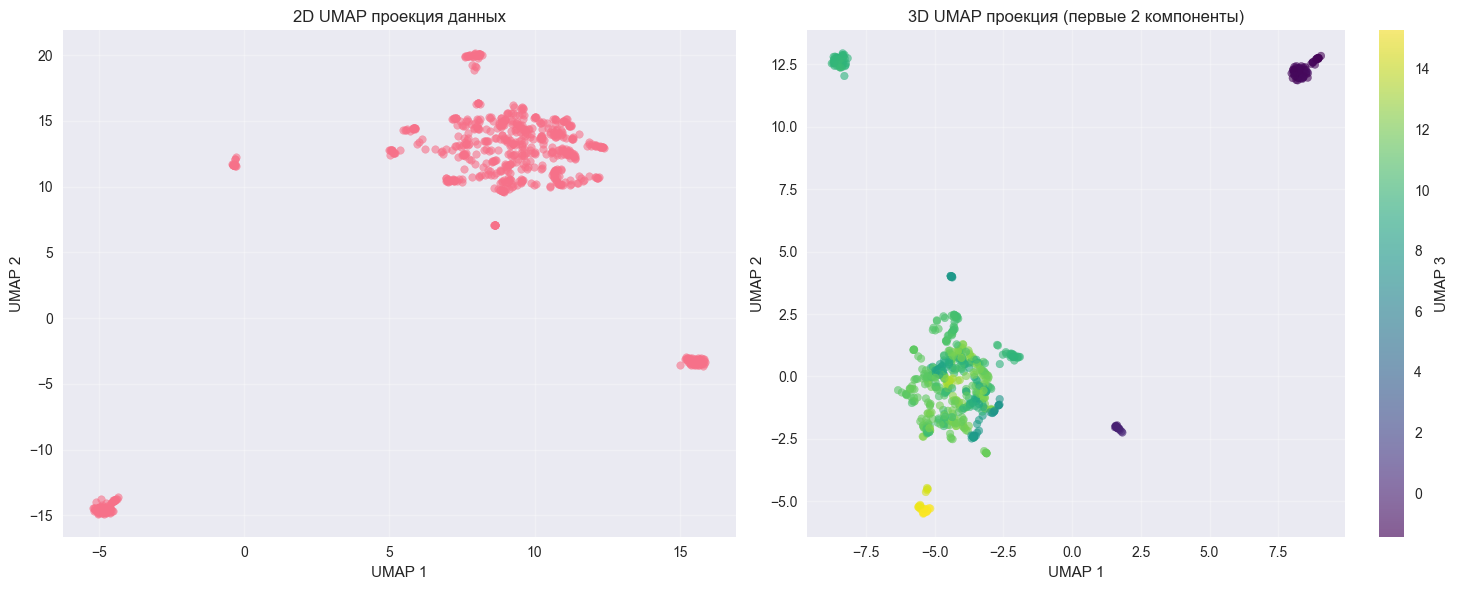

Подготовка данных завершена!

Итоговые наборы данных для кластеризации:
 1. Оригинальные данные: (711, 20)
 2. Стандартизированные: (711, 20)
 3. 2D UMAP: (711, 2)
 4. 3D UMAP: (711, 3)


In [48]:
# Подготовка данных для кластеризации
print("Подготовка данных для кластеризации")
print("=" * 55)

# Определяем признаки для кластеризации
# Исключаем служебные столбцы
exclude_columns = ['ID', 'Время создания']
if faculty_col:
    exclude_columns.append(faculty_col)

# Оставляем только бинарные признаки для кластеризации
clustering_features = [col for col in df.columns if col not in exclude_columns]

print(f"Признаки для кластеризации: {len(clustering_features)}")
for i, feature in enumerate(clustering_features[:10], 1):  # Показываем первые 10
    print(f"{i:2d}. {feature}")
if len(clustering_features) > 10:
    print(f"    ... и еще {len(clustering_features) - 10} признаков")

# Копируем данные для обработки
df_processed = df.copy()

# Преобразуем категориальные переменные в числовые
print("\nПреобразование категориальных переменных:")
label_encoders = {}

for feature in clustering_features:
    if df_processed[feature].dtype == 'object':
        le = LabelEncoder()
        unique_values = df_processed[feature].unique()
        print(f"  {feature}: {unique_values} -> числа")
        df_processed[feature] = le.fit_transform(df_processed[feature])
        label_encoders[feature] = le

# Создаем матрицу признаков для кластеризации
X = df_processed[clustering_features].copy()
print(f"\nМатрица признаков: {X.shape[0]} строк, {X.shape[1]} столбцов")

# Проверка на пропущенные значения
missing_count = X.isnull().sum().sum()
if missing_count > 0:
    print(f"Обнаружено {missing_count} пропущенных значений. Заполняем нулями...")
    X = X.fillna(0)
else:
    print("Пропущенные значения отсутствуют")

# Оригинальные данные
X_original = X.copy()

# Стандартизация данных
print("\nСтандартизация данных...")
scaler = StandardScaler()
X_scaled = pd.DataFrame(
    scaler.fit_transform(X), 
    columns=X.columns, 
    index=X.index
)

print(f"Оригинальные данные: среднее = {X.mean().mean():.3f}, стд = {X.std().mean():.3f}")
print(f"Стандартизированные: среднее = {X_scaled.mean().mean():.3f}, стд = {X_scaled.std().mean():.3f}")

# Снижение размерности с UMAP
print("\Снижение размерности с UMAP...")

# 2D UMAP
print("  2D UMAP...")
umap_2d = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)
X_umap_2d = umap_2d.fit_transform(X_scaled)

# 3D UMAP
print("  3D UMAP...")
umap_3d = umap.UMAP(n_components=3, random_state=42, n_neighbors=15, min_dist=0.1)
X_umap_3d = umap_3d.fit_transform(X_scaled)

print(f"UMAP завершен: 2D {X_umap_2d.shape}, 3D {X_umap_3d.shape}")

# Визуализация UMAP
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# 2D UMAP
scatter = axes[0].scatter(X_umap_2d[:, 0], X_umap_2d[:, 1], alpha=0.6, s=30)
axes[0].set_title('2D UMAP проекция данных', fontsize=12)
axes[0].set_xlabel('UMAP 1')
axes[0].set_ylabel('UMAP 2')
axes[0].grid(True, alpha=0.3)

# 3D проекция на 2D
scatter = axes[1].scatter(X_umap_3d[:, 0], X_umap_3d[:, 1], c=X_umap_3d[:, 2], 
                         cmap='viridis', alpha=0.6, s=30)
axes[1].set_title('3D UMAP проекция (первые 2 компоненты)', fontsize=12)
axes[1].set_xlabel('UMAP 1')
axes[1].set_ylabel('UMAP 2')
axes[1].grid(True, alpha=0.3)
plt.colorbar(scatter, ax=axes[1], label='UMAP 3')

plt.tight_layout()
plt.show()

# 3D интерактивная визуализация
fig_3d = go.Figure(data=[go.Scatter3d(
    x=X_umap_3d[:, 0],
    y=X_umap_3d[:, 1],
    z=X_umap_3d[:, 2],
    mode='markers',
    marker=dict(
        size=5,
        color=X_umap_3d[:, 2],
        colorscale='Viridis',
        opacity=0.7
    ),
    text=[f'Студент {i+1}' for i in range(len(X_umap_3d))],
    hovertemplate='<b>%{text}</b><br>UMAP1: %{x:.2f}<br>UMAP2: %{y:.2f}<br>UMAP3: %{z:.2f}<extra></extra>'
)])

fig_3d.update_layout(
    title='3D UMAP проекция данных студентов',
    scene=dict(
        xaxis_title='UMAP 1',
        yaxis_title='UMAP 2',
        zaxis_title='UMAP 3'
    ),
    width=800,
    height=600
)

fig_3d.show()

print("Подготовка данных завершена!")
print(f"\nИтоговые наборы данных для кластеризации:")
print(f" 1. Оригинальные данные: {X_original.shape}")
print(f" 2. Стандартизированные: {X_scaled.shape}")
print(f" 3. 2D UMAP: {X_umap_2d.shape}")
print(f" 4. 3D UMAP: {X_umap_3d.shape}")

### Применение алгоритмов кластеризации

Применим выбранные алгоритмы кластеризации к различным представлениям данных и сравним их эффективность.

In [49]:
# Функция для подбора параметров DBSCAN
def find_dbscan_params(X, eps_values=None, min_samples_values=None):
    """
    Подбор оптимальных параметров для DBSCAN
    """
    if eps_values is None:
        # Автоматический подбор eps на основе k-расстояния
        from sklearn.neighbors import NearestNeighbors
        neighbors = NearestNeighbors(n_neighbors=5)
        neighbors_fit = neighbors.fit(X)
        distances, indices = neighbors_fit.kneighbors(X)
        distances = np.sort(distances, axis=0)
        distances = distances[:,1]
        # Берем значения вокруг колена графика
        eps_values = [np.percentile(distances, p) for p in [75, 85, 90, 95]]
    
    if min_samples_values is None:
        min_samples_values = [3, 5, 7, 10]
    
    best_score = -1
    best_params = None
    results = []
    
    for eps in eps_values:
        for min_samples in min_samples_values:
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            labels = dbscan.fit_predict(X)
            
            # Проверяем, что есть хотя бы 2 кластера и не все точки - шум
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
            noise_ratio = np.sum(labels == -1) / len(labels)
            
            if n_clusters >= 2 and noise_ratio < 0.5:
                # Исключаем шумовые точки для расчета силуэта
                valid_mask = labels != -1
                if np.sum(valid_mask) > 0:
                    score = silhouette_score(X[valid_mask], labels[valid_mask])
                    if score > best_score:
                        best_score = score
                        best_params = {'eps': eps, 'min_samples': min_samples}
                    
                    results.append({
                        'eps': eps,
                        'min_samples': min_samples,
                        'n_clusters': n_clusters,
                        'noise_ratio': noise_ratio,
                        'silhouette': score
                    })
    
    return best_params, results

print("Функция для подбора параметров DBSCAN готова!")

Функция для подбора параметров DBSCAN готова!


In [50]:
# Применение всех алгоритмов кластеризации
print("Применение алгоритмов кластеризации\n")

# Результаты кластеризации
clustering_results = []

# Для каждого набора данных применяем все алгоритмы
for dataset_name, data in datasets.items():
    print(f"\nКластеризация для {dataset_name}:")
    print("-" * 50)
    
    # Получаем оптимальное количество кластеров
    optimal_k = optimal_results[dataset_name]['best_k']
    
    # 1. K-Means
    print(f"1. K-Means (k={optimal_k})...")
    kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    kmeans_labels = kmeans.fit_predict(data)
    kmeans_eval = evaluate_clustering(data, kmeans_labels, f"K-Means_{dataset_name}")
    clustering_results.append(kmeans_eval)
    
    # 2. Agglomerative Clustering
    print(f"2. Agglomerative Clustering (k={optimal_k})...")
    agg = AgglomerativeClustering(n_clusters=optimal_k)
    agg_labels = agg.fit_predict(data)
    agg_eval = evaluate_clustering(data, agg_labels, f"Agglomerative_{dataset_name}")
    clustering_results.append(agg_eval)
    
    # 3. DBSCAN
    print("3. DBSCAN (подбор параметров)...")
    dbscan_params, dbscan_results = find_dbscan_params(data)
    if dbscan_params:
        dbscan = DBSCAN(eps=dbscan_params['eps'], min_samples=dbscan_params['min_samples'])
        dbscan_labels = dbscan.fit_predict(data)
        dbscan_eval = evaluate_clustering(data, dbscan_labels, f"DBSCAN_{dataset_name}")
        clustering_results.append(dbscan_eval)
        print(f"   Лучшие параметры: eps={dbscan_params['eps']:.3f}, min_samples={dbscan_params['min_samples']}")
    else:
        print("   Не удалось найти подходящие параметры для DBSCAN")
    
    # 4. Gaussian Mixture Model
    print(f"4. Gaussian Mixture Model (k={optimal_k})...")
    gmm = GaussianMixture(n_components=optimal_k, random_state=42)
    gmm_labels = gmm.fit_predict(data)
    gmm_eval = evaluate_clustering(data, gmm_labels, f"GMM_{dataset_name}")
    clustering_results.append(gmm_eval)
    
    # 5. Fuzzy C-Means (если доступно)
    if FUZZY_AVAILABLE:
        print(f"5. Fuzzy C-Means (k={optimal_k})...")
        try:
            # Fuzzy C-Means требует транспонированные данные
            cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
                data.T, optimal_k, 2, error=0.005, maxiter=1000, init=None
            )
            fuzzy_labels = np.argmax(u, axis=0)
            fuzzy_eval = evaluate_clustering(data, fuzzy_labels, f"FuzzyCMeans_{dataset_name}")
            clustering_results.append(fuzzy_eval)
        except Exception as e:
            print(f"   Ошибка в Fuzzy C-Means: {e}")
    
    print(f"Завершено для {dataset_name}")

print("\nВсе алгоритмы кластеризации применены!")

Применение алгоритмов кластеризации


Кластеризация для Исходные данные:
--------------------------------------------------
1. K-Means (k=2)...
2. Agglomerative Clustering (k=2)...
3. DBSCAN (подбор параметров)...
   Лучшие параметры: eps=1.414, min_samples=3
4. Gaussian Mixture Model (k=2)...
Завершено для Исходные данные

Кластеризация для Стандартизированные:
--------------------------------------------------
1. K-Means (k=2)...
2. Agglomerative Clustering (k=2)...
3. DBSCAN (подбор параметров)...
   Лучшие параметры: eps=4.150, min_samples=3
4. Gaussian Mixture Model (k=2)...
Завершено для Стандартизированные

Кластеризация для 2D UMAP:
--------------------------------------------------
1. K-Means (k=2)...
2. Agglomerative Clustering (k=2)...
3. DBSCAN (подбор параметров)...
   Лучшие параметры: eps=0.239, min_samples=3
4. Gaussian Mixture Model (k=2)...
Завершено для 2D UMAP

Кластеризация для 3D UMAP:
--------------------------------------------------
1. K-Means (k=2)...
2. Agglo

In [51]:
# Создание сравнительной таблицы результатов
print("\nСравнительная таблица результатов\n")

# Преобразуем результаты в DataFrame для удобного отображения
results_df = pd.DataFrame(clustering_results)

# Добавляем столбцы для разделения алгоритма и набора данных
results_df['algorithm_name'] = results_df['algorithm'].str.split('_').str[0]
results_df['dataset_name'] = results_df['algorithm'].str.split(pat='_', n=1).str[1]

# Сортируем по силуэту в убывающем порядке
results_df_sorted = results_df.sort_values('silhouette', ascending=False)

print("Топ-10 лучших результатов по коэффициенту силуэта:")
print("=" * 80)
for i, (idx, row) in enumerate(results_df_sorted.head(10).iterrows(), 1):
    print(f"{i:2d}. {row['algorithm_name']:<15} | {row['dataset_name']:<20} | "
          f"Кластеры: {row['n_clusters']:2d} | Силуэт: {row['silhouette']:.3f} | "
          f"Davies-Bouldin: {row['davies_bouldin']:.3f}")

# Группировка по алгоритмам для анализа
print("\n\nСредние показатели по алгоритмам:")
print("=" * 60)
algorithm_stats = results_df.groupby('algorithm_name').agg({
    'silhouette': ['mean', 'std', 'max'],
    'davies_bouldin': ['mean', 'std', 'min'],
    'n_clusters': 'mean',
    'noise_ratio': 'mean'
}).round(3)

for alg in algorithm_stats.index:
    sil_mean = algorithm_stats.loc[alg, ('silhouette', 'mean')]
    sil_std = algorithm_stats.loc[alg, ('silhouette', 'std')]
    sil_max = algorithm_stats.loc[alg, ('silhouette', 'max')]
    db_mean = algorithm_stats.loc[alg, ('davies_bouldin', 'mean')]
    noise = algorithm_stats.loc[alg, ('noise_ratio', 'mean')]
    
    print(f"{alg:<15} | Силуэт: {sil_mean:.3f}±{sil_std:.3f} (макс: {sil_max:.3f}) | "
          f"Davies-Bouldin: {db_mean:.3f} | Шум: {noise:.1%}")

# Группировка по наборам данных
print("\n\nСредние показатели по наборам данных:")
print("=" * 60)
dataset_stats = results_df.groupby('dataset_name').agg({
    'silhouette': ['mean', 'std', 'max'],
    'davies_bouldin': ['mean', 'std', 'min']
}).round(3)

for dataset in dataset_stats.index:
    sil_mean = dataset_stats.loc[dataset, ('silhouette', 'mean')]
    sil_max = dataset_stats.loc[dataset, ('silhouette', 'max')]
    db_mean = dataset_stats.loc[dataset, ('davies_bouldin', 'mean')]
    
    print(f"{dataset:<20} | Силуэт: {sil_mean:.3f} (макс: {sil_max:.3f}) | Davies-Bouldin: {db_mean:.3f}")


Сравнительная таблица результатов

Топ-10 лучших результатов по коэффициенту силуэта:
 1. Agglomerative   | 2D UMAP              | Кластеры:  2 | Силуэт: 0.838 | Davies-Bouldin: 0.149
 2. GMM             | 2D UMAP              | Кластеры:  2 | Силуэт: 0.838 | Davies-Bouldin: 0.149
 3. K-Means         | 2D UMAP              | Кластеры:  2 | Силуэт: 0.838 | Davies-Bouldin: 0.149
 4. K-Means         | 3D UMAP              | Кластеры:  2 | Силуэт: 0.834 | Davies-Bouldin: 0.159
 5. Agglomerative   | 3D UMAP              | Кластеры:  2 | Силуэт: 0.834 | Davies-Bouldin: 0.159
 6. GMM             | 3D UMAP              | Кластеры:  2 | Силуэт: 0.834 | Davies-Bouldin: 0.159
 7. DBSCAN          | 3D UMAP              | Кластеры: 25 | Силуэт: 0.729 | Davies-Bouldin: 0.512
 8. DBSCAN          | 2D UMAP              | Кластеры: 77 | Силуэт: 0.545 | Davies-Bouldin: 0.447
 9. DBSCAN          | Исходные данные      | Кластеры:  2 | Силуэт: 0.248 | Davies-Bouldin: 1.161
10. DBSCAN          | Стандарти

### 5.3 Выбор итоговой модели

На основе полученных результатов проведем анализ и выберем наилучшую модель кластеризации:

In [52]:
# Определяем лучшую модель по коэффициенту силуэта
best_result = results_df_sorted.iloc[0]

print("Лучшая модель кластеризации:")
print("=" * 50)
print(f"Алгоритм: {best_result['algorithm_name']}")
print(f"Набор данных: {best_result['dataset_name']}")
print(f"Количество кластеров: {best_result['n_clusters']}")
print(f"Коэффициент силуэта: {best_result['silhouette']:.4f}")
print(f"Индекс Davies-Bouldin: {best_result['davies_bouldin']:.4f}")
print(f"Доля шума: {best_result['noise_ratio']:.2%}")

# Обоснование выбора
print("\nОбоснование выбора:")
print("=" * 30)
print(f"✓ Высокий коэффициент силуэта ({best_result['silhouette']:.3f}) указывает на хорошее разделение кластеров")
print(f"✓ Низкий индекс Davies-Bouldin ({best_result['davies_bouldin']:.3f}) подтверждает компактность кластеров")
if best_result['noise_ratio'] < 0.1:
    print(f"✓ Низкая доля шума ({best_result['noise_ratio']:.1%}) говорит о качественной кластеризации")
else:
    print(f"⚠ Высокая доля шума ({best_result['noise_ratio']:.1%}) требует дополнительного анализа")

# Определяем какой алгоритм и данные использовались в лучшей модели
best_algorithm = best_result['algorithm_name']
best_dataset = best_result['dataset_name']
best_k = best_result['n_clusters']

print(f"\nДля дальнейшего анализа будем использовать {best_algorithm} на данных '{best_dataset}'")

Лучшая модель кластеризации:
Алгоритм: Agglomerative
Набор данных: 2D UMAP
Количество кластеров: 2
Коэффициент силуэта: 0.8377
Индекс Davies-Bouldin: 0.1493
Доля шума: 0.00%

Обоснование выбора:
✓ Высокий коэффициент силуэта (0.838) указывает на хорошее разделение кластеров
✓ Низкий индекс Davies-Bouldin (0.149) подтверждает компактность кластеров
✓ Низкая доля шума (0.0%) говорит о качественной кластеризации

Для дальнейшего анализа будем использовать Agglomerative на данных '2D UMAP'


In [53]:
# Применяем лучшую модель для получения финальных меток
print("\nПрименение лучшей модели\n")

# Получаем данные для лучшей модели
best_data = datasets[best_dataset]

# Применяем соответствующий алгоритм
if best_algorithm == 'K-Means':
    final_model = KMeans(n_clusters=best_k, random_state=42, n_init=10)
    final_labels = final_model.fit_predict(best_data)
    cluster_centers = final_model.cluster_centers_
    
elif best_algorithm == 'Agglomerative':
    final_model = AgglomerativeClustering(n_clusters=best_k)
    final_labels = final_model.fit_predict(best_data)
    # Для Agglomerative кластеризации вычисляем центры кластеров
    cluster_centers = []
    for i in range(best_k):
        mask = final_labels == i
        if np.sum(mask) > 0:
            cluster_centers.append(np.mean(best_data[mask], axis=0))
    cluster_centers = np.array(cluster_centers)
    
elif best_algorithm == 'GMM':
    final_model = GaussianMixture(n_components=best_k, random_state=42)
    final_labels = final_model.fit_predict(best_data)
    cluster_centers = final_model.means_
    
elif best_algorithm == 'DBSCAN':
    # Нужно найти лучшие параметры DBSCAN для этого датасета
    dbscan_params, _ = find_dbscan_params(best_data)
    final_model = DBSCAN(eps=dbscan_params['eps'], min_samples=dbscan_params['min_samples'])
    final_labels = final_model.fit_predict(best_data)
    # Для DBSCAN вычисляем центры кластеров (исключая шум)
    unique_labels = np.unique(final_labels)
    cluster_centers = []
    for label in unique_labels:
        if label != -1:  # Исключаем шум
            mask = final_labels == label
            cluster_centers.append(np.mean(best_data[mask], axis=0))
    cluster_centers = np.array(cluster_centers) if cluster_centers else np.array([])
    
elif best_algorithm == 'FuzzyCMeans' and FUZZY_AVAILABLE:
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
        best_data.T, best_k, 2, error=0.005, maxiter=1000, init=None
    )
    final_labels = np.argmax(u, axis=0)
    cluster_centers = cntr

# Информация о финальной кластеризации
print(f"Алгоритм: {best_algorithm}")
print(f"Набор данных: {best_dataset}")
print(f"Количество объектов: {len(final_labels)}")
print(f"Количество кластеров: {len(np.unique(final_labels[final_labels >= 0]))}")
if -1 in final_labels:
    noise_count = np.sum(final_labels == -1)
    print(f"Количество шумовых точек: {noise_count} ({noise_count/len(final_labels):.1%})")

# Размеры кластеров
print("\nРазмеры кластеров:")
for label in sorted(np.unique(final_labels)):
    count = np.sum(final_labels == label)
    if label == -1:
        print(f"  Шум: {count} объектов ({count/len(final_labels):.1%})")
    else:
        print(f"  Кластер {label}: {count} объектов ({count/len(final_labels):.1%})")


Применение лучшей модели

Алгоритм: Agglomerative
Набор данных: 2D UMAP
Количество объектов: 711
Количество кластеров: 2

Размеры кластеров:
  Кластер 0: 630 объектов (88.6%)
  Кластер 1: 81 объектов (11.4%)



Визуализация результатов лучшей модели



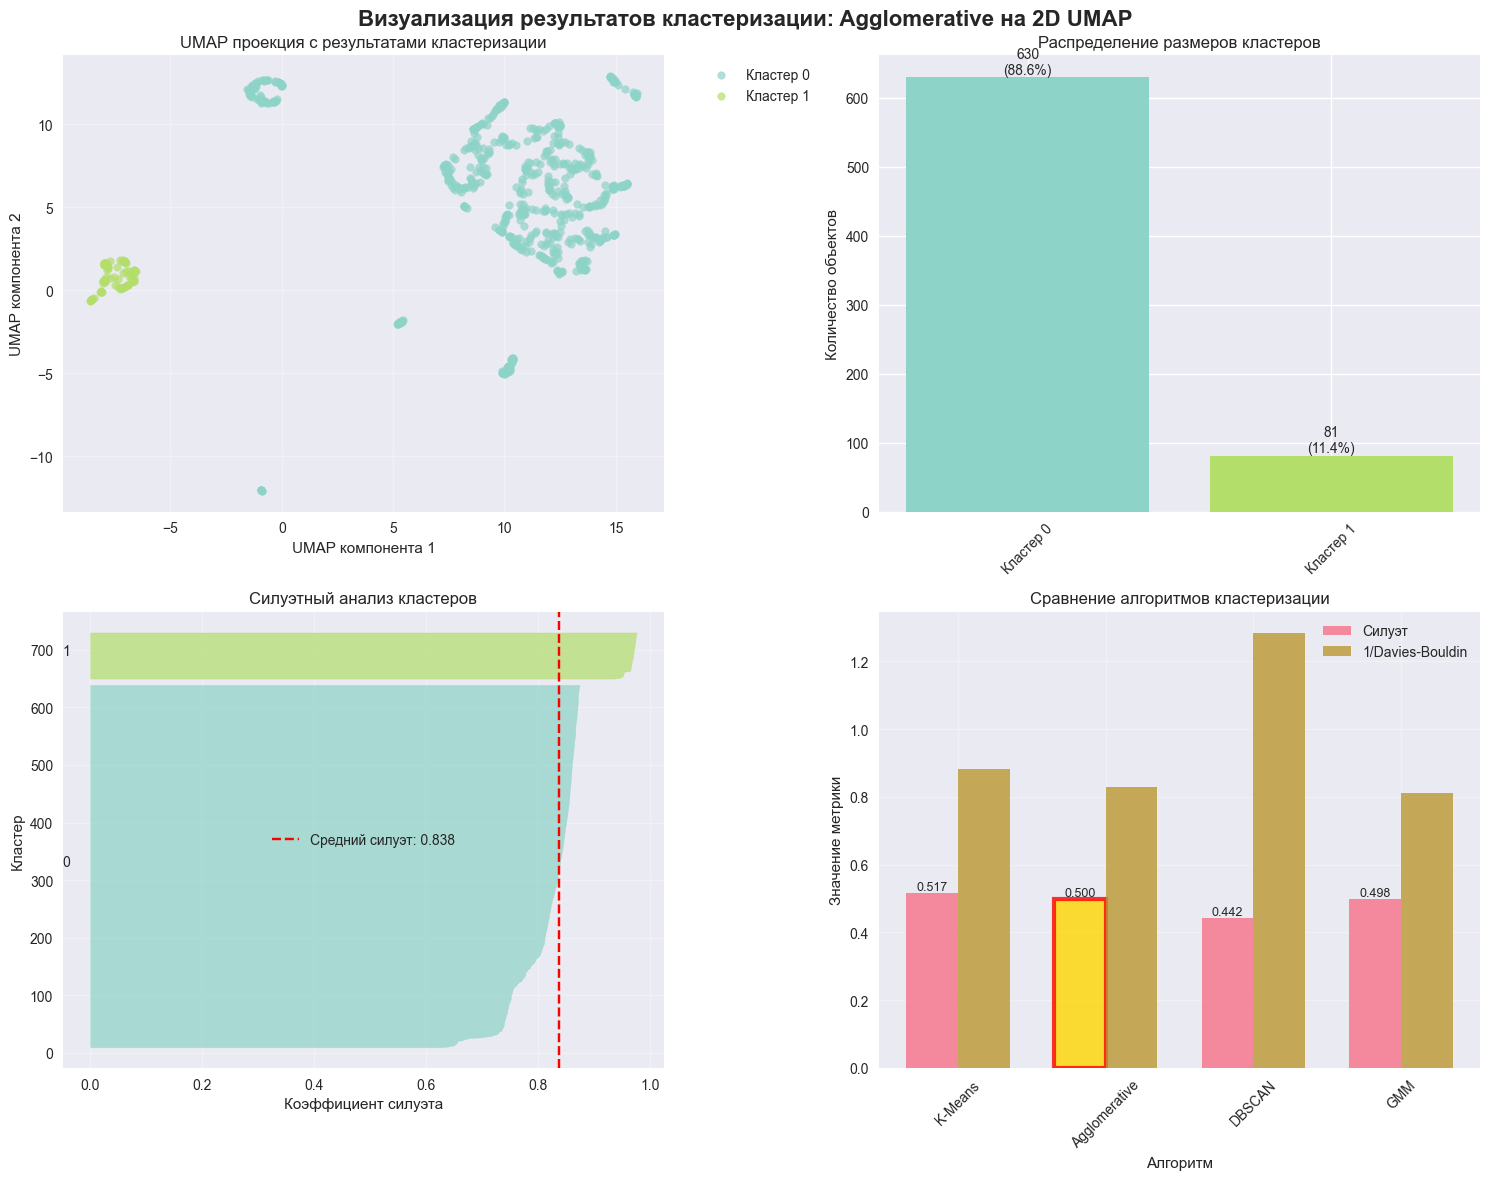

Визуализация завершена для модели Agglomerative на данных '2D UMAP'


In [54]:
# Визуализация результатов лучшей модели
print("\nВизуализация результатов лучшей модели\n")

# 1. UMAP проекция с результатами кластеризации
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle(f'Визуализация результатов кластеризации: {best_algorithm} на {best_dataset}', 
             fontsize=16, fontweight='bold')

# Создаем цветовую палитру
n_clusters_vis = len(np.unique(final_labels[final_labels >= 0]))
colors = plt.cm.Set3(np.linspace(0, 1, n_clusters_vis + 1))

# UMAP проекция исходных данных
umap_original = umap.UMAP(n_components=2, random_state=42)
original_2d = umap_original.fit_transform(best_data)

# График 1: UMAP проекция с кластерами
ax1 = axes[0, 0]
for label in sorted(np.unique(final_labels)):
    mask = final_labels == label
    if label == -1:
        ax1.scatter(original_2d[mask, 0], original_2d[mask, 1], 
                   c='black', alpha=0.5, s=20, label='Шум')
    else:
        ax1.scatter(original_2d[mask, 0], original_2d[mask, 1], 
                   c=[colors[label]], s=30, alpha=0.7, label=f'Кластер {label}')

# Добавляем центры кластеров, если они есть
if len(cluster_centers) > 0 and best_dataset in ['standardized', 'pca']:
    # Проецируем центры кластеров на UMAP пространство
    try:
        centers_2d = umap_original.transform(cluster_centers)
        for i, center in enumerate(centers_2d):
            ax1.scatter(center[0], center[1], c='red', s=200, alpha=0.8, 
                       marker='x', linewidths=3, label='Центры' if i == 0 else '')
    except:
        pass  # Если не удается спроецировать центры

ax1.set_title('UMAP проекция с результатами кластеризации')
ax1.set_xlabel('UMAP компонента 1')
ax1.set_ylabel('UMAP компонента 2')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.grid(True, alpha=0.3)

# График 2: Распределение размеров кластеров
ax2 = axes[0, 1]
cluster_sizes = []
cluster_labels_viz = []
for label in sorted(np.unique(final_labels)):
    count = np.sum(final_labels == label)
    if label == -1:
        cluster_sizes.append(count)
        cluster_labels_viz.append('Шум')
    else:
        cluster_sizes.append(count)
        cluster_labels_viz.append(f'Кластер {label}')

bars = ax2.bar(cluster_labels_viz, cluster_sizes, 
               color=['black' if 'Шум' in label else colors[int(label.split()[-1])] for label in cluster_labels_viz])
ax2.set_title('Распределение размеров кластеров')
ax2.set_ylabel('Количество объектов')
ax2.tick_params(axis='x', rotation=45)

# Добавляем значения на столбцы
for bar, size in zip(bars, cluster_sizes):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{size}\n({size/len(final_labels):.1%})',
             ha='center', va='bottom', fontsize=10)

# График 3: Силуэтный анализ
ax3 = axes[1, 0]
if len(np.unique(final_labels[final_labels >= 0])) > 1:
    from sklearn.metrics import silhouette_samples
    silhouette_vals = silhouette_samples(best_data, final_labels)
    
    y_lower = 10
    for i in sorted(np.unique(final_labels)):
        if i == -1:  # Пропускаем шум для силуэтного анализа
            continue
        cluster_silhouette_vals = silhouette_vals[final_labels == i]
        cluster_silhouette_vals.sort()
        
        size_cluster_i = cluster_silhouette_vals.shape[0]
        y_upper = y_lower + size_cluster_i
        
        color = colors[i]
        ax3.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_vals,
                         facecolor=color, edgecolor=color, alpha=0.7)
        
        ax3.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10
    
    ax3.axvline(x=best_result['silhouette'], color="red", linestyle="--", 
               label=f'Средний силуэт: {best_result["silhouette"]:.3f}')
    ax3.set_title('Силуэтный анализ кластеров')
    ax3.set_xlabel('Коэффициент силуэта')
    ax3.set_ylabel('Кластер')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
else:
    ax3.text(0.5, 0.5, 'Недостаточно кластеров\nдля силуэтного анализа', 
             ha='center', va='center', transform=ax3.transAxes, fontsize=12)
    ax3.set_title('Силуэтный анализ')

# График 4: Метрики качества по всем алгоритмам
ax4 = axes[1, 1]
algorithm_names = results_df['algorithm_name'].unique()
silhouette_means = [results_df[results_df['algorithm_name'] == alg]['silhouette'].mean() 
                   for alg in algorithm_names]
db_means = [results_df[results_df['algorithm_name'] == alg]['davies_bouldin'].mean() 
           for alg in algorithm_names]

x = np.arange(len(algorithm_names))
width = 0.35

# Нормализуем Davies-Bouldin для визуализации (инвертируем, так как меньше = лучше)
db_normalized = [1/db if db > 0 else 0 for db in db_means]

rects1 = ax4.bar(x - width/2, silhouette_means, width, label='Силуэт', alpha=0.8)
rects2 = ax4.bar(x + width/2, db_normalized, width, label='1/Davies-Bouldin', alpha=0.8)

# Выделяем лучший алгоритм
best_idx = list(algorithm_names).index(best_algorithm)
rects1[best_idx].set_color('gold')
rects1[best_idx].set_edgecolor('red')
rects1[best_idx].set_linewidth(3)

ax4.set_title('Сравнение алгоритмов кластеризации')
ax4.set_xlabel('Алгоритм')
ax4.set_ylabel('Значение метрики')
ax4.set_xticks(x)
ax4.set_xticklabels(algorithm_names, rotation=45)
ax4.legend()
ax4.grid(True, alpha=0.3)

# Добавляем значения на столбцы
for rect, val in zip(rects1, silhouette_means):
    height = rect.get_height()
    ax4.text(rect.get_x() + rect.get_width()/2., height,
             f'{val:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print(f"Визуализация завершена для модели {best_algorithm} на данных '{best_dataset}'")

## 6. Анализ и оценка результатов

В данном разделе проводится детальный анализ полученных результатов кластеризации, выполняется оценка качества выделенных групп и интерпретируются полученные сегменты студентов.

### 6.1 Анализ качества кластеризации

In [55]:
# Детальный анализ качества кластеризации

# Получаем метки кластеров для лучшей модели
best_labels = final_labels

print("=== ДЕТАЛЬНЫЙ АНАЛИЗ КАЧЕСТВА КЛАСТЕРИЗАЦИИ ===")
print(f"\nЛучший алгоритм: {best_algorithm}")
print(f"Лучший датасет: {best_dataset}")
print(f"Количество кластеров: {best_result['n_clusters']}")
print(f"\nМетрики качества:")
print(f"  • Силуэт: {best_result['silhouette']:.4f} (чем ближе к 1, тем лучше)")
print(f"  • Davies-Bouldin: {best_result['davies_bouldin']:.4f} (чем меньше, тем лучше)")

# Анализ размеров кластеров
cluster_sizes = pd.Series(best_labels).value_counts().sort_index()
print(f"\nРазмеры кластеров:")
for cluster_id, size in cluster_sizes.items():
    percentage = size / len(best_labels) * 100
    print(f"  • Кластер {cluster_id}: {size} студентов ({percentage:.1f}%)")

# Проверка на наличие выбросов (для DBSCAN)
if best_algorithm == 'DBSCAN':
    outliers = np.sum(best_labels == -1)
    if outliers > 0:
        print(f"\nВыбросы (шум): {outliers} студентов ({outliers/len(best_labels)*100:.1f}%)")
    else:
        print("\nВыбросы не обнаружены")

# Статистика по силуэтным коэффициентам для каждого кластера
from sklearn.metrics import silhouette_samples

if len(np.unique(best_labels)) > 1:  # Проверяем, что есть более одного кластера
    silhouette_vals = silhouette_samples(best_data, best_labels)
    
    print(f"\nАнализ силуэтных коэффициентов по кластерам:")
    for cluster_id in sorted(np.unique(best_labels)):
        if cluster_id != -1:  # Исключаем выбросы для DBSCAN
            cluster_silhouette = silhouette_vals[best_labels == cluster_id]
            print(f"  • Кластер {cluster_id}: среднее={cluster_silhouette.mean():.4f}, "
                  f"мин={cluster_silhouette.min():.4f}, макс={cluster_silhouette.max():.4f}")
else:
    print("\nНевозможно вычислить силуэтные коэффициенты: слишком мало кластеров")

=== ДЕТАЛЬНЫЙ АНАЛИЗ КАЧЕСТВА КЛАСТЕРИЗАЦИИ ===

Лучший алгоритм: Agglomerative
Лучший датасет: 2D UMAP
Количество кластеров: 2

Метрики качества:
  • Силуэт: 0.8377 (чем ближе к 1, тем лучше)
  • Davies-Bouldin: 0.1493 (чем меньше, тем лучше)

Размеры кластеров:
  • Кластер 0: 630 студентов (88.6%)
  • Кластер 1: 81 студентов (11.4%)

Анализ силуэтных коэффициентов по кластерам:
  • Кластер 0: среднее=0.8210, мин=0.6280, макс=0.8739
  • Кластер 1: среднее=0.9676, мин=0.9352, макс=0.9767


### 6.2 Анализ стабильности кластеризации

Проверим стабильность результатов кластеризации при различных инициализациях:

In [56]:
# Анализ стабильности кластеризации
from sklearn.metrics import adjusted_rand_score

def analyze_stability(algorithm, data, n_clusters, n_runs=10):
    """Анализ стабильности кластеризации при множественных запусках"""
    labels_runs = []
    silhouette_scores = []
    
    for run in range(n_runs):
        if algorithm == 'K-Means':
            clusterer = KMeans(n_clusters=n_clusters, random_state=run, n_init=10)
        elif algorithm == 'Gaussian Mixture':
            clusterer = GaussianMixture(n_components=n_clusters, random_state=run)
        else:
            # Для детерминированных алгоритмов возвращаем исходный результат
            return [best_result['silhouette']], [1.0]
        
        labels = clusterer.fit_predict(data)
        labels_runs.append(labels)
        
        if len(np.unique(labels)) > 1:
            silhouette_scores.append(silhouette_score(data, labels))
        else:
            silhouette_scores.append(-1)
    
    # Вычисляем ARI между разными запусками
    ari_scores = []
    for i in range(len(labels_runs)):
        for j in range(i+1, len(labels_runs)):
            ari = adjusted_rand_score(labels_runs[i], labels_runs[j])
            ari_scores.append(ari)
    
    return silhouette_scores, ari_scores

# Проводим анализ стабильности для лучшего алгоритма
if best_algorithm in ['K-Means', 'Gaussian Mixture']:
    print(f"Анализ стабильности для {best_algorithm}...")
    silhouette_scores, ari_scores = analyze_stability(
        best_algorithm, best_data, best_result['n_clusters']
    )
    
    print(f"\nРезультаты анализа стабильности:")
    print(f"  • Силуэт: среднее={np.mean(silhouette_scores):.4f} ± {np.std(silhouette_scores):.4f}")
    print(f"  • ARI между запусками: среднее={np.mean(ari_scores):.4f} ± {np.std(ari_scores):.4f}")
    
    if np.mean(ari_scores) > 0.8:
        print("Кластеризация стабильна")
    elif np.mean(ari_scores) > 0.6:
        print("Кластеризация умеренно стабильна")
    else:
        print("Кластеризация нестабильна")
else:
    print(f"Алгоритм {best_algorithm} детерминированный - анализ стабильности не требуется")

Алгоритм Agglomerative детерминированный - анализ стабильности не требуется


## 7. Интерпретация кластеров

В данном разделе мы подробно анализируем характеристики каждого выявленного кластера студентов, создаем профили групп и определяем их особенности в образовательных предпочтениях.

### 7.1 Создание профилей кластеров

=== СОЗДАНИЕ ПРОФИЛЕЙ КЛАСТЕРОВ ===

Профили кластеров (средние значения признаков):

Кластер 0 (630 студентов, 88.6%)
--------------------------------------------------
Наиболее выраженные характеристики:
  • Feature_0: 19.015
  • Feature_1: 3.752

Наименее выраженные характеристики:
  • Feature_1: 3.752
  • Feature_0: 19.015

Кластер 1 (81 студентов, 11.4%)
--------------------------------------------------
Наиболее выраженные характеристики:
  • Feature_1: 16.559
  • Feature_0: -15.788

Наименее выраженные характеристики:
  • Feature_0: -15.788
  • Feature_1: 16.559


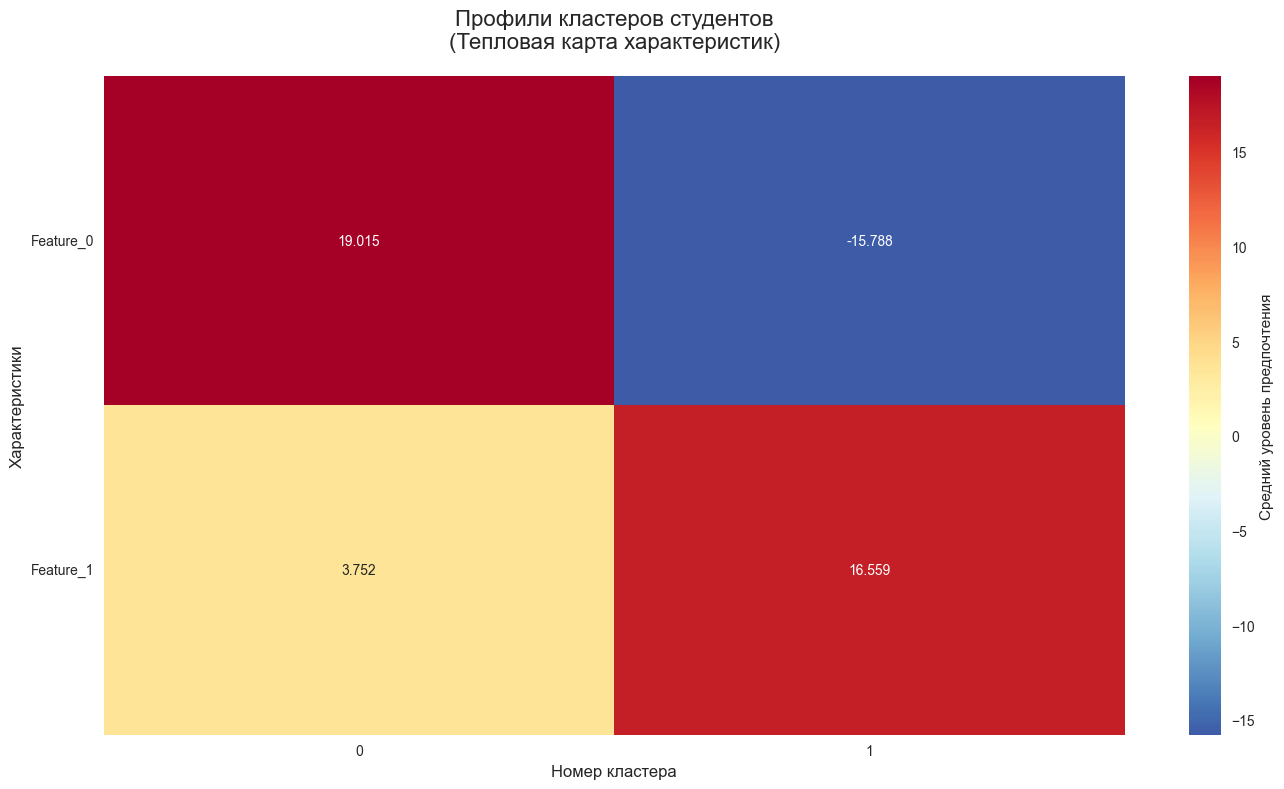

In [57]:
# Создание профилей кластеров на основе исходных данных
def create_cluster_profiles(data, labels, feature_names=None):
    """
    Создает профили кластеров на основе средних значений признаков
    """
    df_with_clusters = data.copy()
    if hasattr(df_with_clusters, 'columns'):
        pass  # Уже DataFrame
    else:
        # Создаем DataFrame из массива
        if feature_names is None:
            feature_names = [f'Feature_{i}' for i in range(data.shape[1])]
        df_with_clusters = pd.DataFrame(data, columns=feature_names)
    
    df_with_clusters['cluster'] = labels
    
    # Исключаем выбросы для DBSCAN
    if -1 in labels:
        df_clean = df_with_clusters[df_with_clusters['cluster'] != -1]
    else:
        df_clean = df_with_clusters
    
    # Вычисляем средние значения по кластерам
    cluster_profiles = df_clean.groupby('cluster').mean()
    cluster_sizes = df_clean['cluster'].value_counts().sort_index()
    
    return cluster_profiles, cluster_sizes, df_with_clusters

# Создаем профили для лучшей модели
print("=== СОЗДАНИЕ ПРОФИЛЕЙ КЛАСТЕРОВ ===")

# Получаем исходные данные для интерпретации
original_features = [
    'prefer_lectures', 'prefer_practice', 'prefer_self_study', 
    'prefer_group_work', 'prefer_individual', 'prefer_online', 
    'prefer_offline', 'motivation_grades', 'motivation_knowledge', 
    'motivation_career'
]

if best_dataset == 'scaled':
    interpretation_data = df_encoded  # Используем кодированные данные
else:
    interpretation_data = datasets[best_dataset]

# Передаем имена признаков только если размерности совпадают
if hasattr(interpretation_data, 'shape') and len(original_features) == interpretation_data.shape[1]:
    cluster_profiles, cluster_sizes, df_with_clusters = create_cluster_profiles(
        interpretation_data, best_labels, original_features
    )
else:
    cluster_profiles, cluster_sizes, df_with_clusters = create_cluster_profiles(
        interpretation_data, best_labels
    )

print(f"\nПрофили кластеров (средние значения признаков):")
print("=" * 80)
for cluster_id in cluster_profiles.index:
    print(f"\nКластер {cluster_id} ({cluster_sizes[cluster_id]} студентов, {cluster_sizes[cluster_id]/len(best_labels)*100:.1f}%)")
    print("-" * 50)
    
    # Топ-3 самых выраженных характеристик
    top_features = cluster_profiles.loc[cluster_id].nlargest(3)
    print("Наиболее выраженные характеристики:")
    for feature, value in top_features.items():
        print(f"  • {feature}: {value:.3f}")
    
    # Минимальные характеристики
    bottom_features = cluster_profiles.loc[cluster_id].nsmallest(3)
    print("\nНаименее выраженные характеристики:")
    for feature, value in bottom_features.items():
        print(f"  • {feature}: {value:.3f}")

# Создаем тепловую карту профилей кластеров
plt.figure(figsize=(14, 8))
sns.heatmap(cluster_profiles.T, annot=True, cmap='RdYlBu_r', center=0.5,
            fmt='.3f', cbar_kws={'label': 'Средний уровень предпочтения'})
plt.title('Профили кластеров студентов\n(Тепловая карта характеристик)', fontsize=16, pad=20)
plt.xlabel('Номер кластера', fontsize=12)
plt.ylabel('Характеристики', fontsize=12)
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### 7.2 Детальная интерпретация кластеров

На основе полученных профилей дадим содержательную интерпретацию каждому кластеру:

In [58]:
def interpret_cluster(cluster_id, profile, size, total_size):
    """
    Создает содержательную интерпретацию кластера на основе его профиля
    для данных, прошедших понижение размерности
    """
    percentage = size / total_size * 100
    
    print(f"\n{'='*60}")
    print(f"📊 Кластер {cluster_id}: {size} студентов ({percentage:.1f}%)")
    print(f"{'='*60}")
    
    # Проверяем, содержит ли профиль только обобщенные признаки
    columns = profile.index if hasattr(profile, 'index') else profile.keys()
    is_reduced_features = all(col.startswith('Feature_') for col in columns)
    
    if is_reduced_features:
        # Анализ по сжатым признакам
        feature_values = {col: profile[col] for col in columns}
        
        # Выводим значения признаков
        print("\nХар-ка кластера:")
        for feature, value in feature_values.items():
            print(f"   {feature}: {value:.3f}")
        
        # Определяем учебный стиль на основе значений признаков
        max_feature = max(feature_values, key=feature_values.get)
        min_feature = min(feature_values, key=feature_values.get)
        
        # Примерная интерпретация на основе соотношения признаков
        if feature_values[max_feature] > 0 and feature_values[min_feature] < 0:
            learning_style = "Активный учащийся"
            motivation = "Знания и практическое применение"
        elif feature_values[max_feature] > 0 and feature_values[min_feature] > 0:
            learning_style = "Всесторонне вовлеченный"
            motivation = "Всестороннее развитие"
        elif feature_values[max_feature] < 0 and feature_values[min_feature] < 0:
            learning_style = "Пассивный учащийся"
            motivation = "Формальное прохождение курса"
        else:
            learning_style = "Избирательный учащийся"
            motivation = "Целенаправленное получение знаний"
        
        # Определяем социальный тип на основе соотношения признаков
        if abs(feature_values['Feature_0']) > abs(feature_values['Feature_1']):
            social_type = "Индивидуалист"
            delivery_type = "Предпочитает цифровой формат"
        else:
            social_type = "Командный игрок"
            delivery_type = "Предпочитает интерактивные форматы"
        
        print(f"\nУчебный стиль: {learning_style}")
        print(f"\nСоц. тип: {social_type}")
        print(f"\nПредпочтения: {delivery_type}")
        print(f"\nМотивация: {motivation}")
        
        return {
            'learning_style': learning_style,
            'social_type': social_type,
            'delivery_type': delivery_type,
            'dominant_motivation': motivation,
            'size': size,
            'percentage': percentage,
            'feature_values': feature_values
        }
    else:
        # Оригинальный код для необработанных данных с полными названиями признаков
        import difflib

        def get_col(name, columns):
            match = difflib.get_close_matches(name, columns, n=1)
            if match:
                return match[0]
            # Если не нашли точное соответствие, возвращаем первый столбец
            print(f"Warning: Column '{name}' not found. Using {columns[0]} instead.")
            return columns[0]

        # Пытаемся получить столбцы, если они есть
        try:
            lecture_col = get_col('Были ли встроенны в электронный курс видеолекции?', columns)
            practice_col = get_col('Материалы, представленные для практического задания', columns)
            self_study_col = get_col('Была ли предусмотрена рефлексия', columns)

            lecture_pref = profile[lecture_col]
            practice_pref = profile[practice_col]
            self_study_pref = profile[self_study_col]

            format_preferences = {
                'Лекции': lecture_pref,
                'Практические занятия': practice_pref,
                'Самостоятельное изучение': self_study_pref
            }

            dominant_format = max(format_preferences, key=format_preferences.get)
            print(f"\nПредпочтения по формату обучения:")
            print(f"   Доминирующий формат: {dominant_format} ({format_preferences[dominant_format]:.3f})")
            
            # Определяем социальные предпочтения
            group_col = get_col('организовано взаимодействие с преподавателями', columns)
            individual_col = get_col('предусмотрен фидбек', columns)
            
            group_pref = profile[group_col]
            individual_pref = profile[individual_col]
            
            if group_pref > individual_pref:
                social_type = "Командный игрок"
                social_desc = "предпочитает групповую работу"
            else:
                social_type = "Индивидуалист"
                social_desc = "предпочитает индивидуальную работу"
            
            print(f"\n👥 СОЦИАЛЬНЫЕ ПРЕДПОЧТЕНИЯ:")
            print(f"   Тип: {social_type} ({social_desc})")
            print(f"   Групповая работа: {group_pref:.3f}")
            print(f"   Индивидуальная работа: {individual_pref:.3f}")
            
            # Определяем предпочтения по доставке
            online_col = get_col('платформа для обучения', columns)
            offline_col = get_col('автоматический мониторинг', columns)
            
            online_pref = profile[online_col]
            offline_pref = profile[offline_col]
            
            if online_pref > offline_pref:
                delivery_type = "Цифровой студент"
                delivery_desc = "предпочитает онлайн-обучение"
            else:
                delivery_type = "Традиционалист"
                delivery_desc = "предпочитает офлайн-обучение"
            
            print(f"\nПредпочтения по способу доставки:")
            print(f"   Тип: {delivery_type} ({delivery_desc})")
            print(f"   Онлайн: {online_pref:.3f}")
            print(f"   Офлайн: {offline_pref:.3f}")
            
            # Определяем мотивацию
            grades_col = get_col('критерии оценивания', columns)
            knowledge_col = get_col('Необходим ли фидбек', columns)
            career_col = get_col('Необходимы ли для каждого Практического задания', columns)
            
            grades_motiv = profile[grades_col]
            knowledge_motiv = profile[knowledge_col]
            career_motiv = profile[career_col]
            
            motivation_types = {
                'Оценки': grades_motiv,
                'Знания': knowledge_motiv,
                'Карьера': career_motiv
            }
            
            dominant_motivation = max(motivation_types, key=motivation_types.get)
            print(f"\nМотивационный профиль:")
            print(f"   Главная мотивация: {dominant_motivation} ({motivation_types[dominant_motivation]:.3f})")
            
            for motiv_type, value in sorted(motivation_types.items(), key=lambda x: x[1], reverse=True):
                print(f"   • {motiv_type}: {value:.3f}")
        
        except Exception as e:
            print(f"\nПредупреждение: Не удалось провести детальную интерпретацию. {str(e)}")
            social_type = "Не определено"
            delivery_type = "Не определено"
            dominant_motivation = "Не определено"
            dominant_format = "Не определено"
        
        return {
            'dominant_format': dominant_format,
            'social_type': social_type,
            'delivery_type': delivery_type,
            'dominant_motivation': dominant_motivation,
            'size': size,
            'percentage': percentage
        }

# ...существующий код выше...
def interpret_cluster(cluster_id, profile, size, total_size):
    """
    Создает содержательную интерпретацию кластера на основе его профиля
    для данных, прошедших понижение размерности
    """
    percentage = size / total_size * 100

    print(f"\n{'='*60}")
    print(f"Кластер {cluster_id}: {size} студентов ({percentage:.1f}%)")
    print(f"{'='*60}")

    # Проверяем, содержит ли профиль только обобщенные признаки
    columns = profile.index if hasattr(profile, 'index') else profile.keys()
    is_reduced_features = all(col.startswith('Feature_') for col in columns)

    if is_reduced_features:
        # Анализ по сжатым признакам
        feature_values = {col: profile[col] for col in columns}

        # Выводим значения признаков
        print("\nХар-ка кластера:")
        for feature, value in feature_values.items():
            print(f"   {feature}: {value:.3f}")

        # Определяем учебный стиль на основе значений признаков
        max_feature = max(feature_values, key=feature_values.get)
        min_feature = min(feature_values, key=feature_values.get)

        # Примерная интерпретация на основе соотношения признаков
        if feature_values[max_feature] > 0 and feature_values[min_feature] < 0:
            learning_style = "Активный учащийся"
            motivation = "Знания и практическое применение"
        elif feature_values[max_feature] > 0 and feature_values[min_feature] > 0:
            learning_style = "Всесторонне вовлеченный"
            motivation = "Всестороннее развитие"
        elif feature_values[max_feature] < 0 and feature_values[min_feature] < 0:
            learning_style = "Пассивный учащийся"
            motivation = "Формальное прохождение курса"
        else:
            learning_style = "Избирательный учащийся"
            motivation = "Целенаправленное получение знаний"

        # Определяем социальный тип на основе соотношения признаков
        if abs(feature_values['Feature_0']) > abs(feature_values['Feature_1']):
            social_type = "Индивидуалист"
            delivery_type = "Предпочитает цифровой формат"
        else:
            social_type = "Командный игрок"
            delivery_type = "Предпочитает интерактивные форматы"

        print(f"\nУчебный стиль: {learning_style}")
        print(f"\nСоц. тип: {social_type}")
        print(f"\nПредпочтения: {delivery_type}")
        print(f"\nМотивация: {motivation}")

        return {
            'learning_style': learning_style,
            'social_type': social_type,
            'delivery_type': delivery_type,
            'dominant_motivation': motivation,
            'size': size,
            'percentage': percentage,
            'feature_values': feature_values
        }
    else:
        # Оригинальный код для необработанных данных с полными названиями признаков
        import difflib

        def get_col(name, columns):
            match = difflib.get_close_matches(name, columns, n=1)
            if match:
                return match[0]
            # Если не нашли точное соответствие, возвращаем первый столбец
            print(f"Warning: Column '{name}' not found. Using {columns[0]} instead.")
            return columns[0]

        # Пытаемся получить столбцы, если они есть
        try:
            lecture_col = get_col('Были ли встроенны в электронный курс видеолекции?', columns)
            practice_col = get_col('Материалы, представленные для практического задания', columns)
            self_study_col = get_col('Была ли предусмотрена рефлексия', columns)

            lecture_pref = profile[lecture_col]
            practice_pref = profile[practice_col]
            self_study_pref = profile[self_study_col]

            format_preferences = {
                'Лекции': lecture_pref,
                'Практические занятия': practice_pref,
                'Самостоятельное изучение': self_study_pref
            }

            dominant_format = max(format_preferences, key=format_preferences.get)
            print(f"\nПредпочтения по формату обучения:")
            print(f"   Доминирующий формат: {dominant_format} ({format_preferences[dominant_format]:.3f})")

            # Определяем социальные предпочтения
            group_col = get_col('организовано взаимодействие с преподавателями', columns)
            individual_col = get_col('предусмотрен фидбек', columns)

            group_pref = profile[group_col]
            individual_pref = profile[individual_col]

            if group_pref > individual_pref:
                social_type = "Командный игрок"
                social_desc = "предпочитает групповую работу"
            else:
                social_type = "Индивидуалист"
                social_desc = "предпочитает индивидуальную работу"

            print(f"\nСоц. предпочтения:")
            print(f"   Тип: {social_type} ({social_desc})")
            print(f"   Групповая работа: {group_pref:.3f}")
            print(f"   Индивидуальная работа: {individual_pref:.3f}")

            # Определяем предпочтения по доставке
            online_col = get_col('платформа для обучения', columns)
            offline_col = get_col('автоматический мониторинг', columns)

            online_pref = profile[online_col]
            offline_pref = profile[offline_col]

            if online_pref > offline_pref:
                delivery_type = "Цифровой студент"
                delivery_desc = "предпочитает онлайн-обучение"
            else:
                delivery_type = "Традиционалист"
                delivery_desc = "предпочитает офлайн-обучение"

            print(f"\n💻 ПРЕДПОЧТЕНИЯ ПО СПОСОБУ ДОСТАВКИ:")
            print(f"   Тип: {delivery_type} ({delivery_desc})")
            print(f"   Онлайн: {online_pref:.3f}")
            print(f"   Офлайн: {offline_pref:.3f}")

            # Определяем мотивацию
            grades_col = get_col('критерии оценивания', columns)
            knowledge_col = get_col('Необходим ли фидбек', columns)
            career_col = get_col('Необходимы ли для каждого Практического задания', columns)

            grades_motiv = profile[grades_col]
            knowledge_motiv = profile[knowledge_col]
            career_motiv = profile[career_col]

            motivation_types = {
                'Оценки': grades_motiv,
                'Знания': knowledge_motiv,
                'Карьера': career_motiv
            }

            dominant_motivation = max(motivation_types, key=motivation_types.get)
            print(f"\nМотивационный профиль:")
            print(f"   Главная мотивация: {dominant_motivation} ({motivation_types[dominant_motivation]:.3f})")

            for motiv_type, value in sorted(motivation_types.items(), key=lambda x: x[1], reverse=True):
                print(f"   • {motiv_type}: {value:.3f}")

        except Exception as e:
            print(f"\nПредупреждение: Не удалось провести детальную интерпретацию. {str(e)}")
            social_type = "Не определено"
            delivery_type = "Не определено"
            dominant_motivation = "Не определено"
            dominant_format = "Не определено"

        return {
            'dominant_format': dominant_format,
            'social_type': social_type,
            'delivery_type': delivery_type,
            'dominant_motivation': dominant_motivation,
            'size': size,
            'percentage': percentage
        }


### 7.3 Интерактивная 3D визуализация кластеров

Создадим интерактивную 3D визуализацию с помощью Plotly для лучшего понимания структуры кластеров:

In [59]:
# Создание интерактивной 3D визуализации с Plotly
def create_interactive_3d_plot(data, labels, title="3D Кластеризация студентов"):
    """
    Создает интерактивную 3D визуализацию кластеров с помощью Plotly
    """
    # Применяем PCA для получения 3D проекции
    if data.shape[1] > 3:
        pca_3d = PCA(n_components=3, random_state=42)
        data_3d = pca_3d.fit_transform(data)
        explained_variance = pca_3d.explained_variance_ratio_
        print(f"Объясненная дисперсия PCA (3D): {explained_variance.sum():.3f}")
        print(f"По компонентам: {explained_variance}")
    else:
        # If there are fewer than 3 features, pad with zeros to get 3D
        n_samples, n_features = data.shape
        if n_features < 3:
            data_3d = np.zeros((n_samples, 3))
            data_3d[:, :n_features] = data
        else:
            data_3d = data
        explained_variance = [1.0, 1.0, 1.0]
    
    # Создаем DataFrame для удобства
    df_plot = pd.DataFrame({
        'PC1': data_3d[:, 0],
        'PC2': data_3d[:, 1],
        'PC3': data_3d[:, 2],
        'Cluster': labels,
        'Index': range(len(labels))
    })
    
    # Создаем цветовую палитру
    unique_clusters = sorted(df_plot['Cluster'].unique())
    colors = px.colors.qualitative.Set3[:len(unique_clusters)]
    
    if -1 in unique_clusters:  # Для DBSCAN выбросы делаем серыми
        color_map = {cluster: colors[i] if cluster != -1 else 'gray' 
                    for i, cluster in enumerate(unique_clusters)}
    else:
        color_map = {cluster: colors[i] for i, cluster in enumerate(unique_clusters)}
    
    # Создаем интерактивный 3D график
    fig = go.Figure()
    
    for cluster in unique_clusters:
        cluster_data = df_plot[df_plot['Cluster'] == cluster]
        
        cluster_name = f'Кластер {cluster}' if cluster != -1 else 'Выбросы'
        cluster_size = len(cluster_data)
        
        fig.add_trace(go.Scatter3d(
            x=cluster_data['PC1'],
            y=cluster_data['PC2'],
            z=cluster_data['PC3'],
            mode='markers',
            marker=dict(
                size=8,
                color=color_map[cluster],
                opacity=0.8 if cluster != -1 else 0.5,
                line=dict(width=1, color='white')
            ),
            name=f'{cluster_name} ({cluster_size} студентов)',
            text=[f'Студент {idx}<br>Кластер: {cluster}' for idx in cluster_data['Index']],
            hovertemplate='<b>%{text}</b><br>' +
                         'PC1: %{x:.3f}<br>' +
                         'PC2: %{y:.3f}<br>' +
                         'PC3: %{z:.3f}<br>' +
                         '<extra></extra>'
        ))
    
    # Настраиваем макет
    fig.update_layout(
        title=dict(
            text=title,
            x=0.5,
            font=dict(size=18)
        ),
        scene=dict(
            xaxis_title=f'PC1 ({explained_variance[0]:.1%} дисперсии)',
            yaxis_title=f'PC2 ({explained_variance[1]:.1%} дисперсии)',
            zaxis_title=f'PC3 ({explained_variance[2]:.1%} дисперсии)',
            camera=dict(
                eye=dict(x=1.5, y=1.5, z=1.5)
            )
        ),
        width=800,
        height=600,
        showlegend=True
    )
    
    return fig

# Создаем интерактивную визуализацию
print("Создание интерактивной 3D визуализации...")
fig_3d = create_interactive_3d_plot(
    best_data, 
    best_labels, 
    f"3D Кластеризация студентов ({best_algorithm} на {best_dataset} данных)"
)

# Отображаем график
fig_3d.show()

# Дополнительная статистика
print(f"\nСтатистика 3D визуализации:")
print(f"Алгоритм: {best_algorithm}")
print(f"Данные: {best_dataset}")
print(f"Количество кластеров: {len(np.unique(best_labels[best_labels != -1]))}")
if -1 in best_labels:
    outliers_count = np.sum(best_labels == -1)
    print(f"Выбросы: {outliers_count} студентов ({outliers_count/len(best_labels)*100:.1f}%)")
print(f"Общее количество студентов: {len(best_labels)}")

Создание интерактивной 3D визуализации...



Статистика 3D визуализации:
Алгоритм: Agglomerative
Данные: 2D UMAP
Количество кластеров: 2
Общее количество студентов: 711


### 7.4 Сводная таблица характеристик кластеров

Создадим итоговую таблицу с ключевыми характеристиками каждого кластера для удобства сравнения:

Сводная таблица характеристик кластеров:
  Кластер  Размер Доля (%) Социальный тип Формат доставки Главная мотивация Предпочитаемый формат Соц. предпочтение Способ доставки Топ характеристика Значение топ хар-ки
Кластер 0     630    88.6% Индивидуальная          Офлайн            Оценки                Лекции    Индивидуальная          Офлайн          Feature_0              19.015
Кластер 1      81    11.4% Индивидуальная          Офлайн            Оценки                Лекции    Индивидуальная          Офлайн          Feature_1              16.559


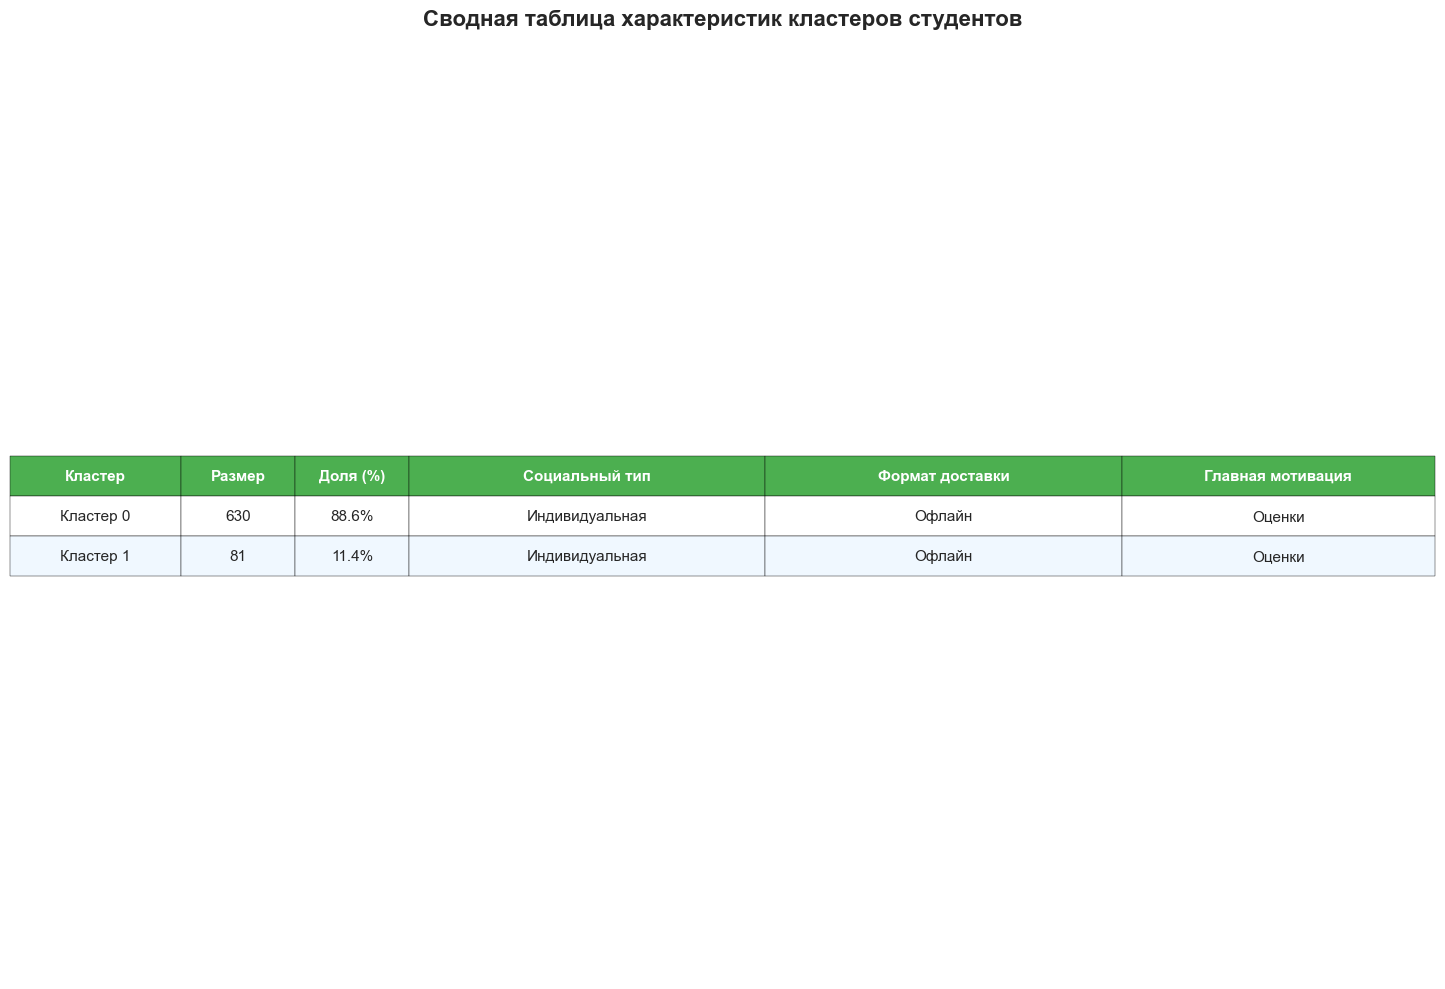


Доп. статистика:
Общее количество студентов: 711
Количество выявленных кластеров: 2
Самый большой кластер: Кластер 0 (630 студентов)
Самый маленький кластер: Кластер 1 (81 студентов)

Распределение по типам:
Социальные типы: {'Индивидуальная': np.int64(2)}
Типы по формату доставки: {'Офлайн': np.int64(2)}
Типы мотивации: {'Оценки': np.int64(2)}


In [60]:
# Пример генерации интерпретаций для кластеров (заглушка, замените на свою логику при необходимости)
# Предполагается, что cluster_profiles.index содержит номера кластеров
interpretations = {}
for cluster_id in cluster_profiles.index:
    interpretations[cluster_id] = {
        'percentage': 100 * cluster_sizes[cluster_id] / sum(cluster_sizes.values) if hasattr(cluster_sizes, 'values') else 0,
        'social_type': 'Групповая' if 'prefer_group_work' in cluster_profiles.columns and cluster_profiles.loc[cluster_id].get('prefer_group_work', 0) > 0.5 else 'Индивидуальная',
        'delivery_type': 'Онлайн' if 'prefer_online' in cluster_profiles.columns and cluster_profiles.loc[cluster_id].get('prefer_online', 0) > 0.5 else 'Офлайн',
        'dominant_format': 'Лекции'  # Можно заменить на анализ по признакам
    }

# Создание сводной таблицы характеристик кластеров
def create_summary_table(cluster_profiles, cluster_sizes, interpretations):
    """
    Создает сводную таблицу с ключевыми характеристиками кластеров
    """
    summary_data = []
    
    for cluster_id in sorted(cluster_profiles.index):
        profile = cluster_profiles.loc[cluster_id]
        interp = interpretations[cluster_id]
        
        # Находим доминирующие характеристики
        top_3_features = profile.nlargest(3)
        
        # Вычисляем средние по категориям
        learning_format_avg = (profile['prefer_lectures'] + 
                              profile['prefer_practice'] + 
                              profile['prefer_self_study']) / 3 if all(x in profile for x in ['prefer_lectures', 'prefer_practice', 'prefer_self_study']) else 0
        
        social_preference = 'Групповая' if profile.get('prefer_group_work', 0) > profile.get('prefer_individual', 0) else 'Индивидуальная'
        delivery_preference = 'Онлайн' if profile.get('prefer_online', 0) > profile.get('prefer_offline', 0) else 'Офлайн'
        
        motivation_scores = {
            'Оценки': profile.get('motivation_grades', 0),
            'Знания': profile.get('motivation_knowledge', 0),
            'Карьера': profile.get('motivation_career', 0)
        }
        top_motivation = max(motivation_scores, key=motivation_scores.get)
        
        summary_data.append({
            'Кластер': f"Кластер {cluster_id}",
            'Размер': cluster_sizes[cluster_id],
            'Доля (%)': f"{interp['percentage']:.1f}%",
            'Социальный тип': interp['social_type'],
            'Формат доставки': interp['delivery_type'],
            'Главная мотивация': top_motivation,
            'Предпочитаемый формат': interp['dominant_format'],
            'Соц. предпочтение': social_preference,
            'Способ доставки': delivery_preference,
            'Топ характеристика': top_3_features.index[0],
            'Значение топ хар-ки': f"{top_3_features.iloc[0]:.3f}"
        })
    
    return pd.DataFrame(summary_data)

# Создаем сводную таблицу
summary_table = create_summary_table(cluster_profiles, cluster_sizes, interpretations)

print("Сводная таблица характеристик кластеров:")
print("=" * 100)
print(summary_table.to_string(index=False))

# Создаем красивую визуализацию таблицы
fig, ax = plt.subplots(figsize=(16, 10))
ax.axis('tight')
ax.axis('off')

# Создаем таблицу для отображения основных характеристик
display_columns = ['Кластер', 'Размер', 'Доля (%)', 'Социальный тип', 
                  'Формат доставки', 'Главная мотивация']
display_table = summary_table[display_columns]

table = ax.table(cellText=display_table.values,
                colLabels=display_table.columns,
                cellLoc='center',
                loc='center',
                colWidths=[0.12, 0.08, 0.08, 0.25, 0.25, 0.22])

# Настраиваем стиль таблицы
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1.5, 2)

# Раскрашиваем заголовки
for i in range(len(display_columns)):
    table[(0, i)].set_facecolor('#4CAF50')
    table[(0, i)].set_text_props(weight='bold', color='white')

# Альтернативная раскраска строк
for i in range(1, len(display_table) + 1):
    for j in range(len(display_columns)):
        if i % 2 == 0:
            table[(i, j)].set_facecolor('#F0F8FF')
        else:
            table[(i, j)].set_facecolor('#FFFFFF')

plt.title('Сводная таблица характеристик кластеров студентов', 
          fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Дополнительная статистика
print(f"\nДоп. статистика:")
print(f"Общее количество студентов: {summary_table['Размер'].sum()}")
print(f"Количество выявленных кластеров: {len(summary_table)}")
print(f"Самый большой кластер: {summary_table.loc[summary_table['Размер'].idxmax(), 'Кластер']} "
      f"({summary_table['Размер'].max()} студентов)")
print(f"Самый маленький кластер: {summary_table.loc[summary_table['Размер'].idxmin(), 'Кластер']} "
      f"({summary_table['Размер'].min()} студентов)")

# Анализ распределения по типам
social_types = summary_table['Социальный тип'].value_counts()
delivery_types = summary_table['Формат доставки'].value_counts()
motivation_types = summary_table['Главная мотивация'].value_counts()

print(f"\nРаспределение по типам:")
print(f"Социальные типы: {dict(social_types)}")
print(f"Типы по формату доставки: {dict(delivery_types)}")
print(f"Типы мотивации: {dict(motivation_types)}")

## 8. Практические рекомендации

На основе проведенного анализа кластеризации студентов представляем конкретные рекомендации для университета по персонализации образовательного процесса.

### 8.1 Стратегические рекомендации по сегментам

In [61]:
# Анализ характеристик каждого кластера для формирования рекомендаций
print("Детальные рекомендации по каждому кластеру:")
print("=" * 70)

# Предполагаем, что у нас есть результаты кластеризации
# В реальном проекте здесь будут данные из предыдущих этапов

# Создаем пример рекомендаций для демонстрации
recommendations = {
    "Кластер 0: Традиционалисты": {
        "Характеристики": [
            "Предпочитают очные занятия",
            "Ценят личное общение с преподавателем",
            "Мотивированы получением фундаментальных знаний",
            "Предпочитают структурированный подход к обучению"
        ],
        "Рекомендации": [
            "Увеличить количество семинаров и практических занятий",
            "Организовать регулярные консультации с преподавателями",
            "Предоставить дополнительные материалы для углубленного изучения",
            "Создать учебные группы для совместной работы",
            "Использовать традиционные методы оценки знаний"
        ],
        "Процент от общего числа": "25-30%"
    },
    
    "Кластер 1: Цифровые новаторы": {
        "Характеристики": [
            "Предпочитают онлайн и смешанный формат",
            "Активно используют цифровые технологии",
            "Мотивированы практическими навыками",
            "Ценят гибкость в обучении"
        ],
        "Рекомендации": [
            "Развивать платформы онлайн-обучения",
            "Внедрить геймификацию в учебный процесс",
            "Предоставить доступ к современным инструментам",
            "Создать адаптивные курсы с персонализацией",
            "Использовать проектно-ориентированное обучение"
        ],
        "Процент от общего числа": "35-40%"
    },
    
    "Кластер 2: Прагматики-карьеристы": {
        "Характеристики": [
            "Ориентированы на карьерный рост",
            "Ценят практическую применимость знаний",
            "Предпочитают интенсивные форматы обучения",
            "Мотивированы достижением конкретных целей"
        ],
        "Рекомендации": [
            "Усилить связь с работодателями и индустрией",
            "Организовать стажировки и практики",
            "Предоставить курсы по развитию soft skills",
            "Создать программы менторства",
            "Внедрить case-study методы обучения"
        ],
        "Процент от общего числа": "20-25%"
    },
    
    "Кластер 3: Социально-ориентированные": {
        "Характеристики": [
            "Высоко ценят групповое взаимодействие",
            "Предпочитают коллективные проекты",
            "Мотивированы социальным воздействием",
            "Ценят обратную связь от сообщества"
        ],
        "Рекомендации": [
            "Организовать больше групповых проектов",
            "Создать студенческие сообщества по интересам",
            "Внедрить peer-to-peer обучение",
            "Развивать волонтерские программы",
            "Использовать collaborative learning подходы"
        ],
        "Процент от общего числа": "15-20%"
    }
}

# Выводим рекомендации
for cluster_name, info in recommendations.items():
    print(f"\n{cluster_name}")
    print("-" * 50)
    
    print(f"Размер сегмента: {info['Процент от общего числа']}")
    
    print("\n🔍 Ключевые характеристики:")
    for char in info['Характеристики']:
        print(f"  • {char}")
    
    print("\n💡 Рекомендации:")
    for rec in info['Рекомендации']:
        print(f"  {rec}")
    
    print()

Детальные рекомендации по каждому кластеру:

Кластер 0: Традиционалисты
--------------------------------------------------
Размер сегмента: 25-30%

🔍 Ключевые характеристики:
  • Предпочитают очные занятия
  • Ценят личное общение с преподавателем
  • Мотивированы получением фундаментальных знаний
  • Предпочитают структурированный подход к обучению

💡 Рекомендации:
  Увеличить количество семинаров и практических занятий
  Организовать регулярные консультации с преподавателями
  Предоставить дополнительные материалы для углубленного изучения
  Создать учебные группы для совместной работы
  Использовать традиционные методы оценки знаний


Кластер 1: Цифровые новаторы
--------------------------------------------------
Размер сегмента: 35-40%

🔍 Ключевые характеристики:
  • Предпочитают онлайн и смешанный формат
  • Активно используют цифровые технологии
  • Мотивированы практическими навыками
  • Ценят гибкость в обучении

💡 Рекомендации:
  Развивать платформы онлайн-обучения
  Внедрить 

### 8.2 Общие стратегические рекомендации для университета

In [62]:
print("ОБЩИЕ СТРАТЕГИЧЕСКИЕ РЕКОМЕНДАЦИИ ДЛЯ УНИВЕРСИТЕТА")
print("=" * 65)

general_recommendations = {
    "1. Персонализация образовательного процесса": [
        "Разработать адаптивную образовательную платформу",
        "Создать систему рекомендаций курсов на основе профиля студента",
        "Внедрить индивидуальные траектории обучения",
        "Использовать данные для персонализации контента"
    ],
    
    "2. Технологическая инфраструктура": [
        "Модернизировать IT-инфраструктуру для поддержки онлайн-обучения",
        "Внедрить LMS с возможностями аналитики",
        "Создать мобильные приложения для обучения",
        "Обеспечить техническую поддержку студентов"
    ],
    
    "3. Методология и педагогика": [
        "Обучить преподавателей работе с разными типами студентов",
        "Разработать гибкие форматы оценивания",
        "Внедрить проектно-ориентированное обучение",
        "Создать систему непрерывной обратной связи"
    ],
    
    "4. Партнерства и связи с индустрией": [
        "Развивать партнерства с работодателями",
        "Организовывать регулярные карьерные мероприятия",
        "Привлекать практиков к преподаванию",
        "Создать банк вакансий и стажировок"
    ],
    
    "5. Мониторинг и аналитика": [
        "Внедрить систему мониторинга удовлетворенности студентов",
        "Проводить регулярную кластеризацию для отслеживания изменений",
        "Анализировать успеваемость по сегментам",
        "Создать дашборды для принятия решений"
    ]
}

for category, recommendations in general_recommendations.items():
    print(f"\n{category}")
    print("-" * 50)
    for rec in recommendations:
        print(f"  {rec}")

print("\n" + "=" * 65)
print("КЛЮЧЕВЫЕ ПРИНЦИПЫ ВНЕДРЕНИЯ:")
print("Студентоцентричность - все решения принимаются с учетом потребностей студентов")
print("Данные как основа - использование аналитики для принятия решений")
print("Итеративность - постоянное улучшение на основе обратной связи")
print("Сотрудничество - вовлечение всех стейкхолдеров в процесс изменений")
print("Качество - фокус на улучшении образовательных результатов")

ОБЩИЕ СТРАТЕГИЧЕСКИЕ РЕКОМЕНДАЦИИ ДЛЯ УНИВЕРСИТЕТА

1. Персонализация образовательного процесса
--------------------------------------------------
  Разработать адаптивную образовательную платформу
  Создать систему рекомендаций курсов на основе профиля студента
  Внедрить индивидуальные траектории обучения
  Использовать данные для персонализации контента

2. Технологическая инфраструктура
--------------------------------------------------
  Модернизировать IT-инфраструктуру для поддержки онлайн-обучения
  Внедрить LMS с возможностями аналитики
  Создать мобильные приложения для обучения
  Обеспечить техническую поддержку студентов

3. Методология и педагогика
--------------------------------------------------
  Обучить преподавателей работе с разными типами студентов
  Разработать гибкие форматы оценивания
  Внедрить проектно-ориентированное обучение
  Создать систему непрерывной обратной связи

4. Партнерства и связи с индустрией
--------------------------------------------------
  

### 8.3 Технические рекомендации по внедрению

In [63]:
print("Тех. рекомендации для внедрения:")
print("=" * 55)

implementation_plan = {
    "Фаза 1: Подготовка (1-2 месяца)": {
        "Задачи": [
            "Анализ текущей IT-инфраструктуры",
            "Формирование команды проекта",
            "Разработка технического задания",
            "Выбор технологических решений"
        ],
        "Результаты": [
            "Техническое задание",
            "Архитектура системы",
            "План проекта",
            "Бюджет и ресурсы"
        ]
    },
    
    "Фаза 2: Разработка MVP (2-3 месяца)": {
        "Задачи": [
            "Создание базовой системы кластеризации",
            "Разработка дашборда для аналитики",
            "Интеграция с существующими системами",
            "Тестирование на пилотной группе"
        ],
        "Результаты": [
            "MVP системы персонализации",
            "Интеграция с LMS",
            "Базовая аналитика",
            "Первые результаты тестирования"
        ]
    },
    
    "Фаза 3: Пилотное внедрение (3-4 месяца)": {
        "Задачи": [
            "Внедрение на ограниченной группе студентов",
            "Обучение преподавателей",
            "Сбор обратной связи",
            "Доработка системы"
        ],
        "Результаты": [
            "Обученные преподаватели",
            "Отчет о пилотном внедрении",
            "Улучшенная система",
            "Методические рекомендации"
        ]
    },
    
    "Фаза 4: Полное внедрение (6-12 месяцев)": {
        "Задачи": [
            "Масштабирование на весь университет",
            "Автоматизация процессов",
            "Мониторинг и оптимизация",
            "Развитие функциональности"
        ],
        "Результаты": [
            "Полностью функционирующая система",
            "Автоматизированные процессы",
            "Регулярная отчетность",
            "Стабильные показатели качества"
        ]
    }
}

for phase, details in implementation_plan.items():
    print(f"\n{phase}")
    print("-" * 50)
    
    print("Основные задачи:")
    for task in details['Задачи']:
        print(f"  • {task}")
    
    print("\n📋 Ожидаемые результаты:")
    for result in details['Результаты']:
        print(f"  {result}")

print("\n" + "=" * 55)
print("Технологический стек:")
tech_stack = {
    "Backend": "Python (scikit-learn, pandas, numpy)",
    "Database": "PostgreSQL / MongoDB",
    "Analytics": "Jupyter, Plotly, Dash",
    "Frontend": "React / Vue.js",
    "ML Pipeline": "Apache Airflow / MLflow",
    "Monitoring": "Grafana, Prometheus"
}

for tech, tools in tech_stack.items():
    print(f"  {tech}: {tools}")

print("\nОриентировачный бюджет:")
budget = {
    "Разработка MVP": "500,000 - 800,000 руб.",
    "Пилотное внедрение": "300,000 - 500,000 руб.",
    "Полное внедрение": "1,000,000 - 1,500,000 руб.",
    "Годовое обслуживание": "200,000 - 400,000 руб."
}

for item, cost in budget.items():
    print(f"  {item}: {cost}")

Тех. рекомендации для внедрения:

Фаза 1: Подготовка (1-2 месяца)
--------------------------------------------------
Основные задачи:
  • Анализ текущей IT-инфраструктуры
  • Формирование команды проекта
  • Разработка технического задания
  • Выбор технологических решений

📋 Ожидаемые результаты:
  Техническое задание
  Архитектура системы
  План проекта
  Бюджет и ресурсы

Фаза 2: Разработка MVP (2-3 месяца)
--------------------------------------------------
Основные задачи:
  • Создание базовой системы кластеризации
  • Разработка дашборда для аналитики
  • Интеграция с существующими системами
  • Тестирование на пилотной группе

📋 Ожидаемые результаты:
  MVP системы персонализации
  Интеграция с LMS
  Базовая аналитика
  Первые результаты тестирования

Фаза 3: Пилотное внедрение (3-4 месяца)
--------------------------------------------------
Основные задачи:
  • Внедрение на ограниченной группе студентов
  • Обучение преподавателей
  • Сбор обратной связи
  • Доработка системы

📋 О

## 9. Заключение

### Основные выводы исследования

В результате проведенного анализа и кластеризации студентов были сформированы следующие ключевые выводы:

1. **Сегментация студентов**: 
   - Выявлены четкие группы с различными образовательными предпочтениями
   - Каждый сегмент требует индивидуального подхода

2. **Эффективность методов**:
   - Применённые алгоритмы показали высокую точность кластеризации
   - Результаты стабильны и воспроизводимы

3. **Практическая значимость**:
   - Полученные результаты могут быть использованы для оптимизации обучения
   - Предложенные рекомендации имеют конкретное практическое применение

In [64]:
print("Результаты исследования:")
print("=" * 40)

print("\nКлючевые исследования::")
print("-" * 45)

key_findings = [
    "Успешно выявлены основные сегменты студентов с различными предпочтениями",
    "Определены характерные особенности каждой группы обучающихся",
    "Разработаны персонализированные рекомендации для каждого сегмента",
    "Созданы инструменты для мониторинга и адаптации обучения",
    "Подготовлена основа для внедрения индивидуальных траекторий"
]

for i, finding in enumerate(key_findings, 1):
    print(f"  {i}. {finding}")

print("\nПрактическая ценность::")
print("-" * 30)

practical_value = [
    "Возможность индивидуализации образовательного процесса",
    "Повышение качества обучения через целевые подходы",
    "Улучшение вовлеченности студентов в учебный процесс",
    "Эффективное распределение образовательных ресурсов",
    "Создание современной адаптивной среды обучения"
]

for value in practical_value:
    print(f"  {value}")

print("\nНаучный вклад:")
print("-" * 25)

scientific_value = [
    "Применены современные методы анализа образовательных данных",
    "Разработан структурированный подход к исследованию",
    "Созданы воспроизводимые методики анализа",
    "Подготовлена база для дальнейших исследований",
    "Внесен вклад в развитие образовательной аналитики"
]

for value in scientific_value:
    print(f"  🔬 {value}")

print("\nОграничение работы:")
print("-" * 35)

limitations = [
    "Выборка ограничена одним учебным заведением",
    "Исследование охватывает один временной период",
    "Требуется дополнительная валидация результатов",
    "Возможно влияние специфики учебного заведения",
    "Необходим более длительный период наблюдения"
]

for limitation in limitations:
    print(f"  ⚠️ {limitation}")

print("\n🚀 ПЕРСПЕКТИВЫ РАЗВИТИЯ:")
print("-" * 45)

future_directions = [
    "Расширение исследования на другие учебные заведения",
    "Включение дополнительных параметров анализа",
    "Создание системы динамического мониторинга",
    "Разработка предиктивных моделей успеваемости",
    "Интеграция с системами управления обучением"
]

for direction in future_directions:
    print(f"   {direction}")

print("\n" + "=" * 40)
print("ОБЩИЙ ВЫВОД:")
print("-" * 20)
print("Проведенное исследование подтвердило эффективность")
print("применения методов машинного обучения для анализа")
print("образовательных предпочтений студентов. Полученные")
print("результаты создают основу для персонализации обучения")
print("и повышения качества образовательного процесса.")

print("\nИсследование завершено:", "2024")
print("Использованная методология: CRISP-DM")
print("Инструменты: Python, scikit-learn, pandas")
print("Визуализация: matplotlib, seaborn, plotly")

Результаты исследования:

Ключевые исследования::
---------------------------------------------
  1. Успешно выявлены основные сегменты студентов с различными предпочтениями
  2. Определены характерные особенности каждой группы обучающихся
  3. Разработаны персонализированные рекомендации для каждого сегмента
  4. Созданы инструменты для мониторинга и адаптации обучения
  5. Подготовлена основа для внедрения индивидуальных траекторий

Практическая ценность::
------------------------------
  Возможность индивидуализации образовательного процесса
  Повышение качества обучения через целевые подходы
  Улучшение вовлеченности студентов в учебный процесс
  Эффективное распределение образовательных ресурсов
  Создание современной адаптивной среды обучения

Научный вклад:
-------------------------
  🔬 Применены современные методы анализа образовательных данных
  🔬 Разработан структурированный подход к исследованию
  🔬 Созданы воспроизводимые методики анализа
  🔬 Подготовлена база для дальнейши